In [140]:
import numpy as np
import george
from george import kernels
from scipy.optimize import minimize
from time import time
from sklearn.decomposition import PCA
from scipy.optimize import minimize


import pickle
import matplotlib.pyplot as plt

In [71]:
def orig_to_trans(pars):
    gamma=pars[6]
    logM_env=pars[8]
    beta=pars[7]
    incl=pars[14]
    
    pars[6]=np.log10(2.1-1*gamma)
    pars[8]=np.log10(-1.5-1*logM_env)
    
    s=np.sin(0.7)
    c=np.cos(0.7)
    
    pars[7]=1-np.cos(((beta*c) + (incl*s/60)-.5)*np.pi/2)
    pars[14]=(-beta*s) + (incl*c/60)
    return pars

def trans_to_orig(pars):
    gamma_trans=pars[6]
    logM_env_trans=pars[8]
    bi_x=pars[7]
    bi_y=pars[14]
    
    pars[6]=2.1 - 10**gamma_trans
    pars[8]=-1.5 - 10**logM_env_trans
    
    s=np.sin(0.7)
    c=np.cos(0.7)
    
    pars[7]=round((1/(c+(s**2/c)))*((2/np.pi)*np.arccos(1-bi_x)+0.5-(s/c)*bi_y),14)
    pars[14]=round((60*s)*((2/np.pi)*np.arccos(1-bi_x)+0.5+(c/s)*bi_y),14)
    return pars

In [72]:
param_names = ["Tstar","logLstar","logMdisk","logRdisk","h0","logRin",\
               "gamma","beta","logMenv","logRenv","fcav","ksi","logamax","p","incl"]

seds_dict=np.load("./etgrid/et_dictionary_seds.npy",allow_pickle=True)

seds=np.load("./etgrid/seds.npy",allow_pickle=True)[:,100:500]
nanseds=np.load("./etgrid/seds.npy",allow_pickle=True)[:,100:500]
xvals=np.load("./etgrid/xvals.npy",allow_pickle=True)

# fix -infs: powerlaw cutoff
for i in range(len(seds)):
    if -np.inf in seds[i]:
        a = seds[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = seds[i][ind]
        for j in range(ind):
            seds[i][j]=(100*(np.log10(xvals[j]/x1)))+y1

np.save("./etgrid/sedsflat.npy",np.ndarray.flatten(seds))
            
# subtracting from each SED its sample mean
nanseds[nanseds<-20]=np.nan
seds_msub = seds - np.nanmean(nanseds,axis=1)[:,np.newaxis]


# run PCA
pca = PCA(n_components=40).fit(seds_msub)
print("PCA finished")
eigenseds=np.array(pca.components_)

post=np.load("posteriors.npy")

PCA finished


In [92]:
priors=np.load("priors.npy")

In [95]:
post0=np.zeros(16)
post0[0]=5
for i in range(15):
    post0[i+1]=np.mean(priors[i][0:2])

In [99]:
conv=np.load("./etgrid/3962_cobyla_convergence.npy")

In [84]:
with open ('./gmd/cubefull.txt', 'rb') as fp:
    old_grid = np.array(pickle.load(fp))
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]
    
xvals=np.load("./etgrid/xvals.npy")
orig_dict=np.load("./gmd/dictionary.npy",allow_pickle=True)

def point(i):
    coo=[]
    for j in param_names:
        coo.append(orig_dict[i][j])
    transcoo=orig_to_trans(coo)
    sed = old_grid[i][100:500]
    return (transcoo, sed)

np.random.seed(seed=100)
sample=np.random.randint(0,3850,50)
sample_coords=[]
sample_seds=[]
sample_nanseds=[]
for i in range(len(sample)):
    sample_coords.append(point(sample[i])[0])
    sample_seds.append(point(sample[i])[1])
    sample_nanseds.append(point(sample[i])[1])
    
sample_nanseds=np.array(sample_nanseds)
    
# fix -infs: powerlaw cutoff
for i in range(len(sample_seds)):
    if -np.inf in sample_seds[i]:
        a = sample_seds[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = sample_seds[i][ind]
        for j in range(ind):
            sample_seds[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# subtracting from each SED its sample mean
sample_nanseds[sample_nanseds<-20]=np.nan
sample_seds_msub = sample_seds - np.nanmean(sample_nanseds,axis=1)[:,np.newaxis]

In [85]:
sample_w2_pca=[]
for i in range(len(sample)):
    sample_w2_pca.append(pca.transform(sample_seds_msub[i].reshape(1,-1))[0][2])

In [86]:
inst = "3976"

coords=np.load("./etgrid/"+inst+"_coords.npy")
eigenseds=np.load("./etgrid/"+inst+"_eigenseds.npy")
weights=np.load("./etgrid/"+inst+"_weights.npy")
pcamean=np.load("./etgrid/"+inst+"_mean.npy")

yerrs=[]
for i in range(16):
    yerrs.append([x*0.02 for x in weights[i]])


In [87]:
kernel = 16*kernels.ExpSquaredKernel(15**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=5)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=14) 
blankhodlr=george.GP(kernel)

In [88]:
def pred2(pred_coords,fit):
    gp=blankhodlr
    gp.set_parameter_vector(fit)
    gp.compute(coords,yerrs[2])
    pred, pred_var = gp.predict(weights[2], pred_coords, return_var=True)
    return pred

In [96]:
sample_w2_pred=pred2(sample_coords,post)
sample_w2_pred0=pred2(sample_coords,post0)

In [100]:
sample_w2_pred_conv500=pred2(sample_coords,conv[500][2])

In [102]:
sample_w2_pred_conv0=pred2(sample_coords,conv[0][2])

In [104]:
sample_w2_pred_conv999=pred2(sample_coords,conv[999][2])

In [105]:
disc=sample_w2_pred-sample_w2_pca
print(np.mean(disc))

disc=sample_w2_pred0-sample_w2_pca
print(np.mean(disc))

disc=sample_w2_pred_conv0-sample_w2_pca
print(np.mean(disc))

disc=sample_w2_pred_conv500-sample_w2_pca
print(np.mean(disc))

disc=sample_w2_pred_conv999-sample_w2_pca
print(np.mean(disc))

5.215035962783843
5.251086715249825
4.871653119361401
4.9445656328883665
5.251085774668968


In [106]:
def pred(pred_coords,fit):
    gp=blankhodlr
    preds=[]
    hyperparams=np.array(fit).reshape(16,16)

    for i in range(len(weights)): 
        gp.set_parameter_vector(hyperparams[i])
        gp.compute(coords,yerrs[i])
        pred, pred_var = gp.predict(weights[i], pred_coords, return_var=True)
        preds.append(pred)
    reconst_SEDs=[]
    for i in range(len(pred_coords)):
        reconst=np.dot(np.array(preds)[:,i][0:15],eigenseds[0:15]) + pcamean + np.array(preds)[:,i][15]
        reconst_SEDs.append(reconst)
    return reconst_SEDs, preds


In [107]:
t0=time()
predicted_SEDs_0, predicted_weights_0 =pred(sample_coords,guess)
print(time()-t0)

66.89597296714783


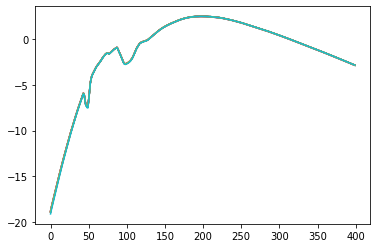

In [113]:
for i in range(10):
    plt.plot(predicted_SEDs_0[i])

1544
{'Tstar': 4199.56641046421, 'logL_star': 2.85281592655843, 'logM_disk': -2.9294592209991137, 'logR_disk': 2.6005302095205782, 'h_0': 0.48148388493241095, 'logR_in': 2.411200414040263, 'gamma': 1.3361703107586127, 'beta': 0.5449035498648207, 'logM_env': -2.7676289670969743, 'logR_env': 2.9978825572768706, 'f_cav': 0.15876738316292802, 'ksi': 0.9376541507186984, 'loga_max': 1.2044723013274434, 'p': 3.1420625184243183, 'incl': 23.91888271543316, 'filename': 'Tstar_4199.5_logLstar_2.853_logMdisk_-2.929_logRdisk_2.601_h0_0.481_logRin_2.411_gamma_1.336_beta_0.545_logMenv_-2.768_logRenv_2.998_fcav_0.159_ksi_0.938_logamax_1.204_p_3.142_incl_23.919.hdf5'}


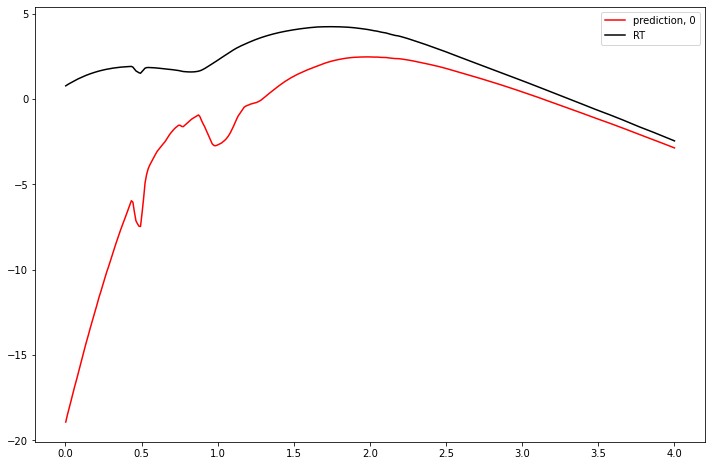

2840
{'Tstar': 4052.8048072165525, 'logL_star': -0.4742031739038671, 'logM_disk': -4.228589610120597, 'logR_disk': 1.763773247302657, 'h_0': 0.4796235759694844, 'logR_in': 1.6580309076501392, 'gamma': 1.203584753211446, 'beta': 0.9785615607933034, 'logM_env': -4.906667147230664, 'logR_env': 2.5668119746434144, 'f_cav': 0.1619997771792713, 'ksi': 1.173007176881626, 'loga_max': 4.564234372964447, 'p': 3.2608146680097074, 'incl': 33.85544274847727, 'filename': 'Tstar_4052.805_logLstar_-0.474_logMdisk_-4.229_logRdisk_1.764_h0_0.480_logRin_1.658_gamma_1.204_beta_0.979_logMenv_-4.907_logRenv_2.567_fcav_0.162_ksi_1.173_logamax_4.564_p_3.261_incl_33.855.hdf5'}


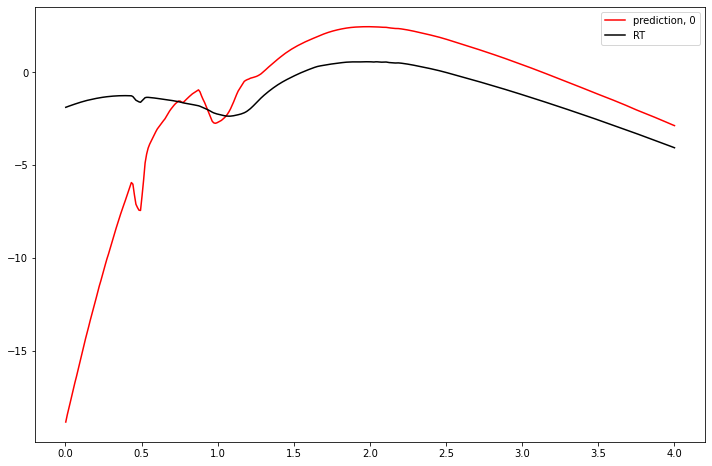

1859
{'Tstar': 4029.2376513363897, 'logL_star': 2.234230973874895, 'logM_disk': -2.3648041462095586, 'logR_disk': 2.699583931692943, 'h_0': 0.07521493457337713, 'logR_in': 1.142650412712904, 'gamma': 1.9482092047210953, 'beta': 1.7456961100349904, 'logM_env': -2.9409731107398613, 'logR_env': 3.0757015460936454, 'f_cav': 0.3434932407464302, 'ksi': 0.9698045873542, 'loga_max': 1.2965151229063323, 'p': 3.827831526941049, 'incl': 80.01807242539384, 'filename': 'Tstar_4029.238_logLstar_2.234_logMdisk_-2.365_logRdisk_2.700_h0_0.075_logRin_1.143_gamma_1.948_beta_1.746_logMenv_-2.941_logRenv_3.076_fcav_0.343_ksi_0.970_logamax_1.297_p_3.828_incl_80.018.hdf5'}


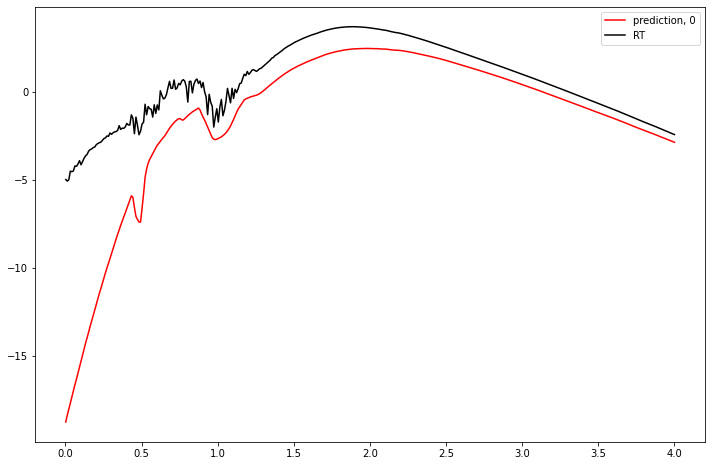

79
{'Tstar': 4779.74572740921, 'logL_star': 1.2035221606204258, 'logM_disk': -3.176570822055808, 'logR_disk': 2.344218226405769, 'h_0': 0.20338573167725715, 'logR_in': 1.376547975382309, 'gamma': 0.12764949232708775, 'beta': 0.6329341856580698, 'logM_env': -5.922527778667542, 'logR_env': 3.8783377965228665, 'f_cav': 0.326418004559722, 'ksi': 1.367718672239917, 'loga_max': 0.21121971203187148, 'p': 3.987688998186959, 'incl': 36.911080842343736, 'filename': 'Tstar_4779.746_logLstar_1.204_logMdisk_-3.177_logRdisk_2.344_h0_0.203_logRin_1.377_gamma_0.128_beta_0.633_logMenv_-5.923_logRenv_3.878_fcav_0.326_ksi_1.368_logamax_0.211_p_3.9_incl_36.911.hdf5'}


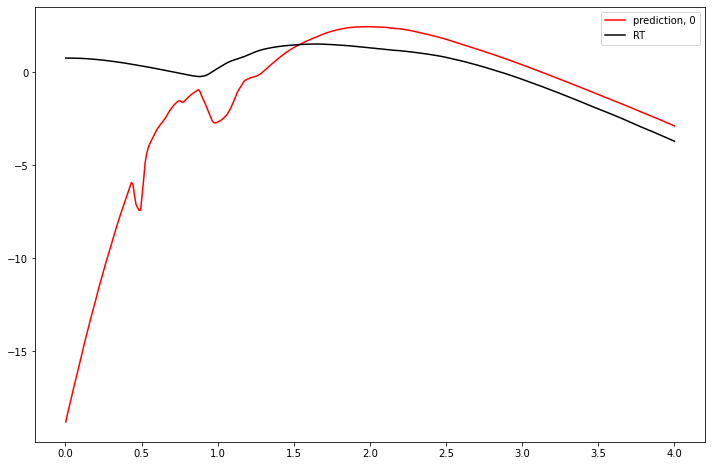

1930
{'Tstar': 3750.6160473368404, 'logL_star': 0.07063834883906495, 'logM_disk': -7.5256094372949045, 'logR_disk': 2.575600237037094, 'h_0': 0.22237062825324522, 'logR_in': -0.943368010970529, 'gamma': 1.2070509522541761, 'beta': 1.7727390001047882, 'logM_env': -4.191627232423801, 'logR_env': 3.6785470643910427, 'f_cav': 0.9256782959967308, 'ksi': 0.8061490007161071, 'loga_max': 3.300505788487768, 'p': 2.513688000125866, 'incl': 86.74634387553989, 'filename': 'Tstar_3750.616_logLstar_0.071_logMdisk_-7.526_logRdisk_2.576_h0_0.222_logRin_-0.943_gamma_1.207_beta_1.773_logMenv_-4.192_logRenv_3.679_fcav_0.926_ksi_0.806_logamax_3.301_p_2.514_incl_86.746.hdf5'}


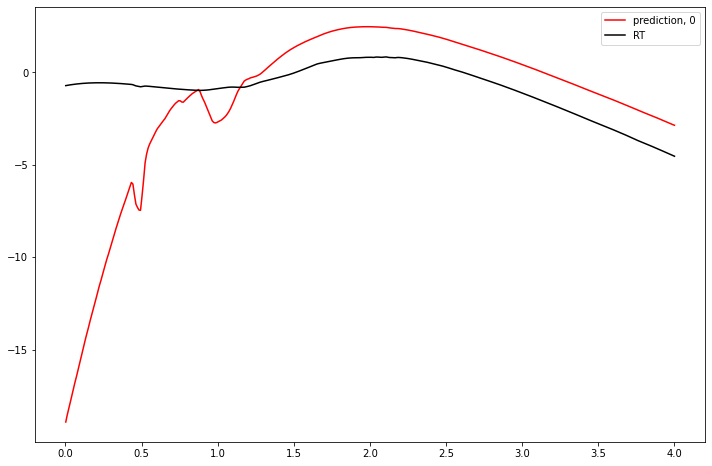

350
{'Tstar': 4767.9162266312815, 'logL_star': 0.98941933488109, 'logM_disk': -5.209147515709161, 'logR_disk': 2.5889612720562236, 'h_0': 0.18023293032267354, 'logR_in': -0.3719901200135831, 'gamma': 0.38517367151471615, 'beta': 1.7146132811352919, 'logM_env': -4.842130098684873, 'logR_env': 2.6247494648054075, 'f_cav': 0.38113405160896063, 'ksi': 1.229983366379741, 'loga_max': 4.306013096365408, 'p': 2.8014082125781403, 'incl': 74.59087167996526, 'filename': 'Tstar_4767.916_logLstar_0.989_logMdisk_-5.209_logRdisk_2.589_h0_0.180_logRin_-0.372_gamma_0.385_beta_1.715_logMenv_-4.842_logRenv_2.625_fcav_0.381_ksi_1.230_logamax_4.306_p_2.801_incl_74.591.hdf5'}


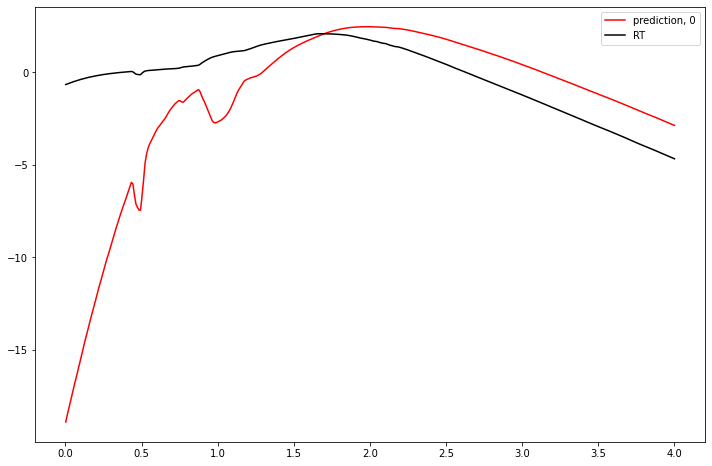

1972
{'Tstar': 4486.27245534445, 'logL_star': -0.07074306334691838, 'logM_disk': -7.2269343082776665, 'logR_disk': 1.5863746026615297, 'h_0': 0.20078018232873113, 'logR_in': -0.7346116517686951, 'gamma': 0.6004589191622374, 'beta': 1.739519762423241, 'logM_env': -4.623097297733166, 'logR_env': 2.7843395053046924, 'f_cav': 0.2154624996366238, 'ksi': 0.7577638228791266, 'loga_max': 2.872259880276085, 'p': 4.441168738109081, 'incl': 79.23681640816815, 'filename': 'Tstar_4486.272_logLstar_-0.071_logMdisk_-7.227_logRdisk_1.586_h0_0.201_logRin_-0.735_gamma_0.600_beta_1.740_logMenv_-4.623_logRenv_2.784_fcav_0.215_ksi_0.758_logamax_2.872_p_4.441_incl_79.237.hdf5'}


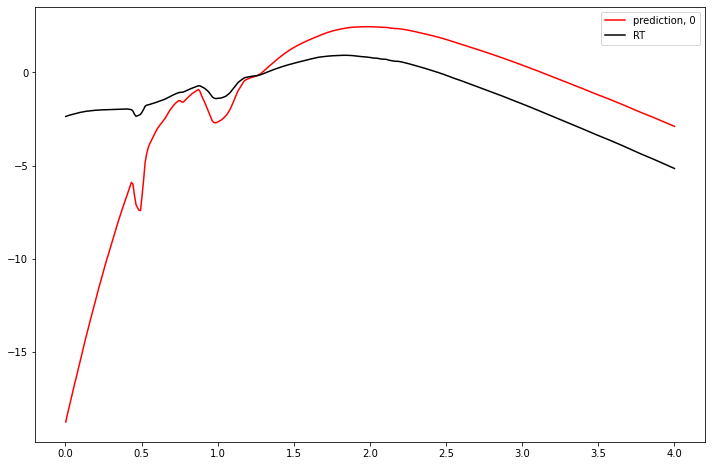

1890
{'Tstar': 3014.245589912348, 'logL_star': 0.19473622476599206, 'logM_disk': -6.528221935797542, 'logR_disk': 1.1101747893507599, 'h_0': 0.05132665915870634, 'logR_in': -0.18002863590521956, 'gamma': 1.7492165201811851, 'beta': 1.5025966390137941, 'logM_env': -3.333353515842207, 'logR_env': 3.7807698934758887, 'f_cav': 0.24447950021963266, 'ksi': 1.2783679681070688, 'loga_max': 2.9430891628238296, 'p': 4.104814333046452, 'incl': 55.61527716718773, 'filename': 'Tstar_3014.246_logLstar_0.195_logMdisk_-6.528_logRdisk_1.110_h0_0.051_logRin_-0.180_gamma_1.749_beta_1.503_logMenv_-3.333_logRenv_3.781_fcav_0.244_ksi_1.278_logamax_2.943_p_4.105_incl_55.615.hdf5'}


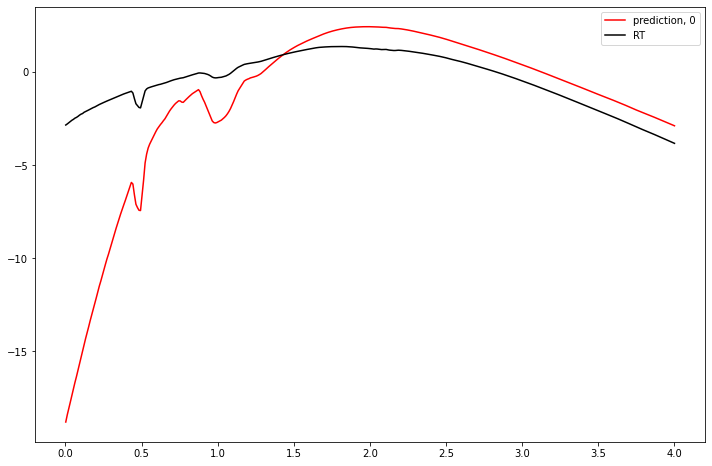

53
{'Tstar': 4614.3676229251905, 'logL_star': 0.8522860093606823, 'logM_disk': -6.067903024133363, 'logR_disk': 2.3798801956962174, 'h_0': 0.14232506886024587, 'logR_in': 0.3725567885975196, 'gamma': 0.2777084739979055, 'beta': 1.9957573860222213, 'logM_env': -5.679639861665991, 'logR_env': 2.504689235772373, 'f_cav': 0.0391751755772318, 'ksi': 0.9250726349031282, 'loga_max': 4.430782703253755, 'p': 4.142100270901226, 'incl': 11.956077733891332, 'filename': 'Tstar_4614.368_logLstar_0.852_logMdisk_-6.068_logRdisk_2.380_h0_0.142_logRin_0.373_gamma_0.278_beta_1.996_logMenv_-5.680_logRenv_2.505_fcav_0.039_ksi_0.925_logamax_4.431_p_4.142_incl_11.956.hdf5'}


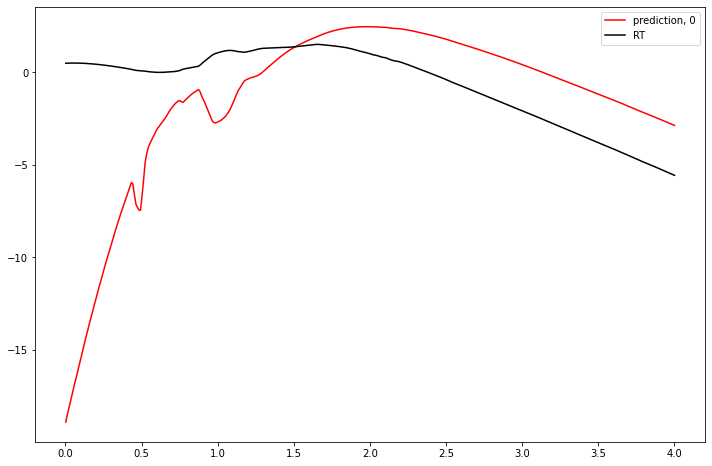

1602
{'Tstar': 3092.5484065445894, 'logL_star': -0.018425403870834134, 'logM_disk': -4.5623764496983785, 'logR_disk': 2.0316919098019444, 'h_0': 0.07926248847728218, 'logR_in': 0.8695641205449665, 'gamma': 0.28977102841681684, 'beta': 1.2841334537640468, 'logM_env': -2.010838409583676, 'logR_env': 3.511483355878613, 'f_cav': 0.9307793402236059, 'ksi': 1.148219269522774, 'loga_max': 4.2726604501895125, 'p': 3.6938858582942995, 'incl': 86.10711198226981, 'filename': 'Tstar_3092.548_logLstar_-0.018_logMdisk_-4.562_logRdisk_2.032_h0_0.079_logRin_0.870_gamma_0.290_beta_1.284_logMenv_-2.011_logRenv_3.511_fcav_0.931_ksi_1.148_logamax_4.273_p_3.694_incl_86.107.hdf5'}


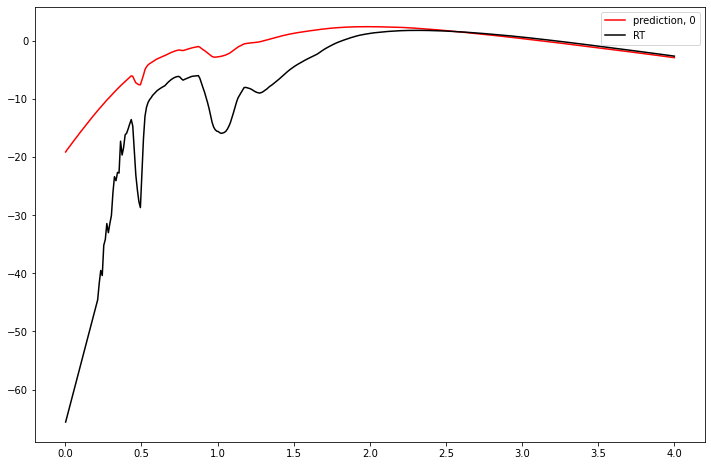

3810
{'Tstar': 4924.110890838527, 'logL_star': 2.104373627628623, 'logM_disk': -6.26373634439922, 'logR_disk': 2.8310163633135534, 'h_0': 0.2830503737981903, 'logR_in': 0.9323103387876435, 'gamma': 1.8329255552532804, 'beta': 0.5884822775124575, 'logM_env': -4.4475276780355415, 'logR_env': 3.2570772754540176, 'f_cav': 0.507206131092625, 'ksi': 1.4629832330147723, 'loga_max': 0.5510926416591311, 'p': 3.591234070814182, 'incl': 70.39621179929549, 'filename': 'Tstar_4924.111_logLstar_2.104_logMdisk_-6.264_logRdisk_2.831_h0_0.283_logRin_0.932_gamma_1.833_beta_0.5_logMenv_-4.448_logRenv_3.257_fcav_0.507_ksi_1.463_logamax_0.551_p_3.591_incl_70.396.hdf5'}


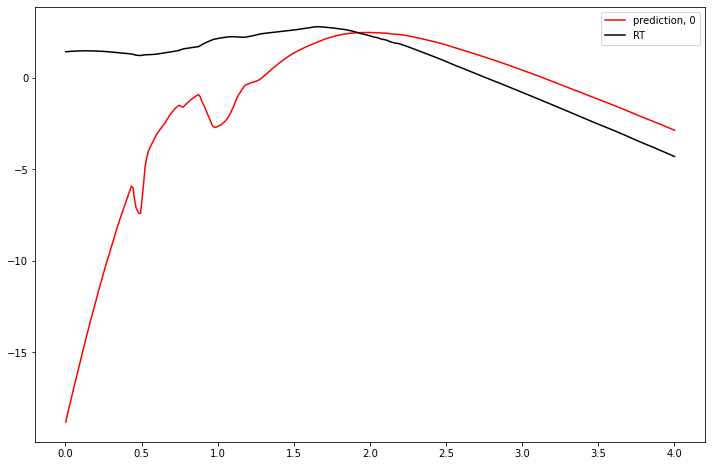

1550
{'Tstar': 4785.375438430417, 'logL_star': 2.5164126312826056, 'logM_disk': -4.908363760494549, 'logR_disk': 2.1330321721779937, 'h_0': 0.18464319782793082, 'logR_in': 2.0490280342589244, 'gamma': 0.6042882341369182, 'beta': 1.5135495135476527, 'logM_env': -6.518184975108711, 'logR_env': 3.737660079654396, 'f_cav': 0.9630744637167712, 'ksi': 1.1590153757554282, 'loga_max': 1.798107505201369, 'p': 3.8067750627565267, 'incl': 1.2938721171843404, 'filename': 'Tstar_4785.375_logLstar_2.516_logMdisk_-4.908_logRdisk_2.133_h0_0.185_logRin_2.049_gamma_0.604_beta_1.514_logMenv_-6.518_logRenv_3.738_fcav_0.963_ksi_1.159_logamax_1.798_p_3.807_incl_1.294.hdf5'}


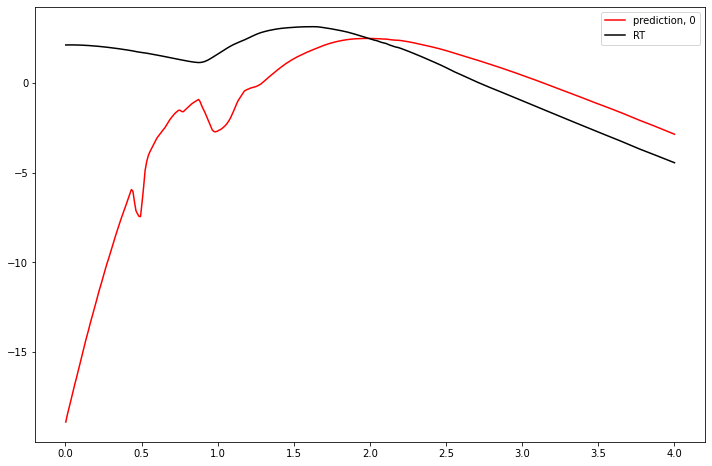

802
{'Tstar': 3444.336758132988, 'logL_star': 0.9160346912086301, 'logM_disk': -4.585116547143086, 'logR_disk': 0.038679209589679256, 'h_0': 0.09748400933670588, 'logR_in': -0.8483959036213986, 'gamma': 1.7440470552555778, 'beta': 1.8807938466579248, 'logM_env': -3.936536627281516, 'logR_env': 2.86254440231316, 'f_cav': 0.5062212727246473, 'ksi': 1.1862114239883348, 'loga_max': 4.2169723891327475, 'p': 3.2411578502974887, 'incl': 82.50180753406511, 'filename': 'Tstar_3444.337_logLstar_0.916_logMdisk_-4.585_logRdisk_0.039_h0_0.097_logRin_-0.848_gamma_1.744_beta_1.1_logMenv_-3.937_logRenv_2.863_fcav_0.506_ksi_1.186_logamax_4.217_p_3.241_incl_82.502.hdf5'}


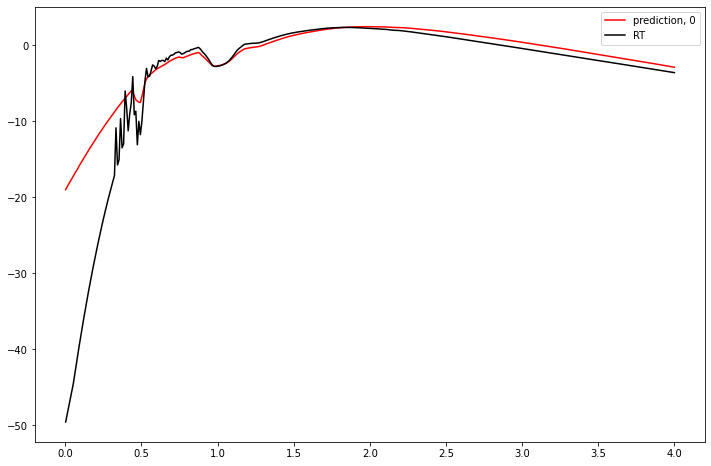

1009
{'Tstar': 3597.390355798113, 'logL_star': 2.5748184052949243, 'logM_disk': -7.134982857320346, 'logR_disk': 0.9877080334058372, 'h_0': 0.3383171024926534, 'logR_in': 0.4303047030676739, 'gamma': 1.851141289861225, 'beta': 1.2235287275794478, 'logM_env': -6.144282023344728, 'logR_env': 3.4652395772340148, 'f_cav': 0.8844837192029494, 'ksi': 0.9651992936881952, 'loga_max': 4.500041889568793, 'p': 2.6579296254937046, 'incl': 53.10162435091543, 'filename': 'Tstar_3597.390_logLstar_2.575_logMdisk_-7.135_logRdisk_0.9_h0_0.338_logRin_0.430_gamma_1.851_beta_1.224_logMenv_-6.144_logRenv_3.465_fcav_0.4_ksi_0.965_logamax_4.500_p_2.658_incl_53.102.hdf5'}


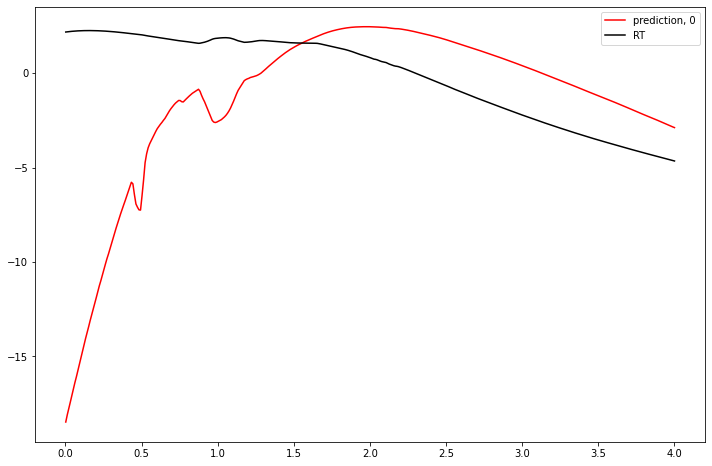

2800
{'Tstar': 4029.601174429621, 'logL_star': 1.7916861057382807, 'logM_disk': -3.2905950547027762, 'logR_disk': 1.6790516489720564, 'h_0': 0.38685234731907103, 'logR_in': -0.31292117500956884, 'gamma': 1.3285760240021234, 'beta': 1.4428400525005765, 'logM_env': -5.103573946838927, 'logR_env': 2.5036494649828978, 'f_cav': 0.03216930010923854, 'ksi': 0.8707131603229454, 'loga_max': 4.46651960526967, 'p': 3.614771765499568, 'incl': 8.424696397911674, 'filename': 'Tstar_4029.601_logLstar_1.792_logMdisk_-3.291_logRdisk_1.679_h0_0.387_logRin_-0.313_gamma_1.329_beta_1.443_logMenv_-5.104_logRenv_2.504_fcav_0.032_ksi_0.871_logamax_4.467_p_3.615_incl_8.425.hdf5'}


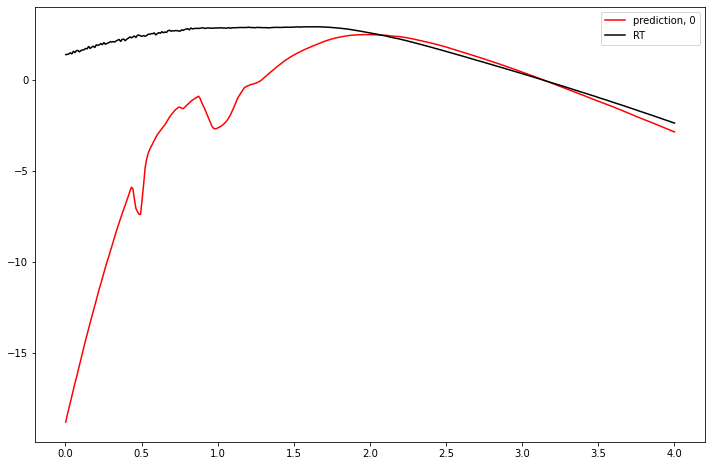

280
{'Tstar': 4650.612041535343, 'logL_star': 2.4873264872766883, 'logM_disk': -2.260927628075647, 'logR_disk': 2.5319991509475863, 'h_0': 0.1783658202900315, 'logR_in': 0.4439068697656583, 'gamma': 0.6949083402941749, 'beta': 1.1117770020409803, 'logM_env': -4.745992141612678, 'logR_env': 3.779998856472985, 'f_cav': 0.8716610100564751, 'ksi': 0.5567536829045185, 'loga_max': 3.7998097158385837, 'p': 3.269579759265182, 'incl': 43.717823819043474, 'filename': 'Tstar_4650.612_logLstar_2.487_logMdisk_-2.261_logRdisk_2.532_h0_0.178_logRin_0.444_gamma_0.695_beta_1.112_logMenv_-4.746_logRenv_3.780_fcav_0.872_ksi_0.557_logamax_3.800_p_3.270_incl_43.718.hdf5'}


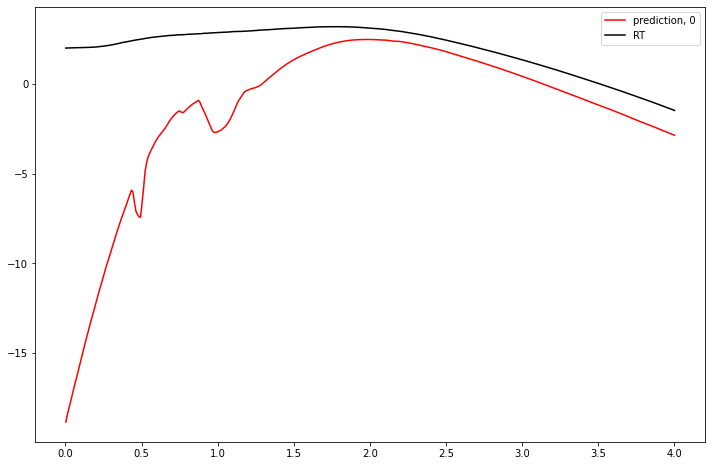

1679
{'Tstar': 4288.799343983849, 'logL_star': -0.9288665114429228, 'logM_disk': -7.658402669421195, 'logR_disk': 1.9245215385942358, 'h_0': 0.36507987521903834, 'logR_in': 1.7017763282443026, 'gamma': 0.42192392237064186, 'beta': 1.9626888050795832, 'logM_env': -7.108144550979619, 'logR_env': 3.813730315564117, 'f_cav': 0.45423351308426474, 'ksi': 1.2301230234514524, 'loga_max': 1.739341273375451, 'p': 3.7659069458131067, 'incl': 14.267926264815117, 'filename': 'Tstar_42.799_logLstar_-0.929_logMdisk_-7.658_logRdisk_1.925_h0_0.365_logRin_1.702_gamma_0.422_beta_1.963_logMenv_-7.108_logRenv_3.814_fcav_0.454_ksi_1.230_logamax_1.739_p_3.7_incl_14.268.hdf5'}


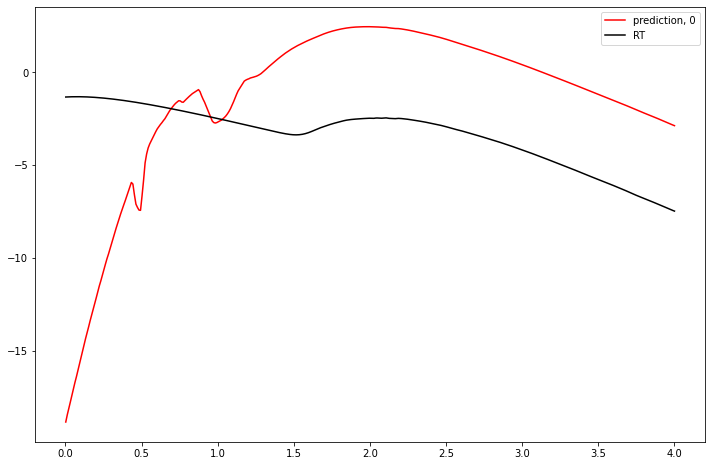

3300
{'Tstar': 4911.838860800345, 'logL_star': -0.35124801320027044, 'logM_disk': -3.8551380861165034, 'logR_disk': 1.069724422125515, 'h_0': 0.24766366322947334, 'logR_in': 0.3086957019626224, 'gamma': 1.1607113238750721, 'beta': 0.8071180562933201, 'logM_env': -5.902077737231829, 'logR_env': 3.742964028632144, 'f_cav': 0.7128249517620528, 'ksi': 1.1387408493077826, 'loga_max': 1.485842354412092, 'p': 3.6096263202448213, 'incl': 28.016259950918606, 'filename': 'Tstar_4911.839_logLstar_-0.351_logMdisk_-3.855_logRdisk_1.070_h0_0.248_logRin_0.309_gamma_1.161_beta_0.807_logMenv_-5.902_logRenv_3.743_fcav_0.713_ksi_1.139_logamax_1.486_p_3.610_incl_28.016.hdf5'}


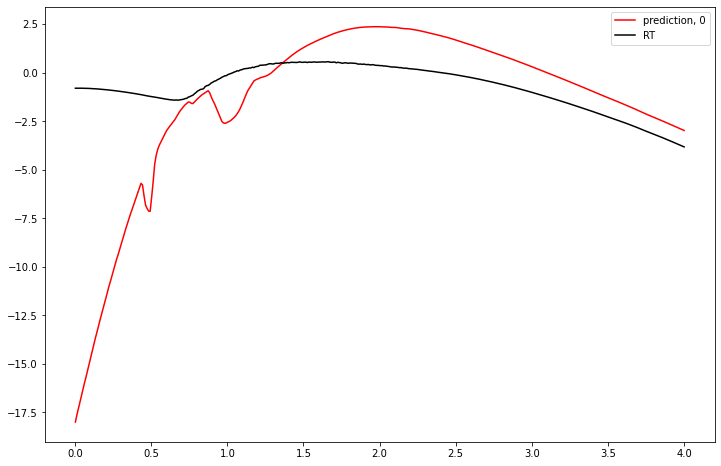

1899
{'Tstar': 3818.855901204626, 'logL_star': 1.0873937031964567, 'logM_disk': -6.470287257728607, 'logR_disk': 2.7291033383624277, 'h_0': 0.04586132949867563, 'logR_in': 1.833852780359925, 'gamma': 0.066132761939193, 'beta': 0.6584941806278257, 'logM_env': -7.505860738684125, 'logR_env': 2.961037417035236, 'f_cav': 0.6318895406610214, 'ksi': 1.2053342886295213, 'loga_max': 0.41578940045996304, 'p': 4.327616619732357, 'incl': 4.721673600554363, 'filename': 'Tstar_3818.856_logLstar_1.087_logMdisk_-6.470_logRdisk_2.729_h0_0.046_logRin_1.834_gamma_0.0_beta_0.658_logMenv_-7.506_logRenv_2.961_fcav_0.632_ksi_1.205_logamax_0.416_p_4.328_incl_4.722.hdf5'}


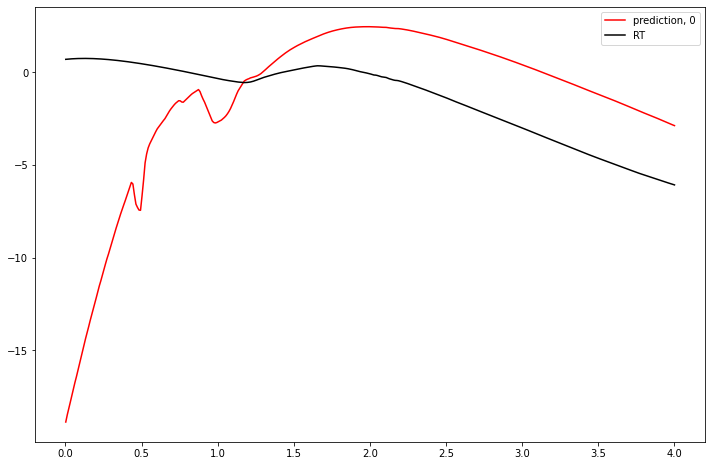

1340
{'Tstar': 3667.5663132614795, 'logL_star': 2.6422904903810145, 'logM_disk': -6.322110709372498, 'logR_disk': 1.499689533044973, 'h_0': 0.4727439593974678, 'logR_in': 0.10514469912055557, 'gamma': 0.8552393817826958, 'beta': 1.2686098465640878, 'logM_env': -5.431201813886107, 'logR_env': 2.962638627891985, 'f_cav': 0.7448074113352504, 'ksi': 0.6149210487039471, 'loga_max': 4.871410149062822, 'p': 4.363248110403292, 'incl': 82.1817958131453, 'filename': 'Tstar_37.5_logLstar_2.642_logMdisk_-6.322_logRdisk_1.500_h0_0.473_logRin_0.105_gamma_0.855_beta_1.269_logMenv_-5.431_logRenv_2.963_fcav_0.745_ksi_0.615_logamax_4.871_p_4.363_incl_82.182.hdf5'}


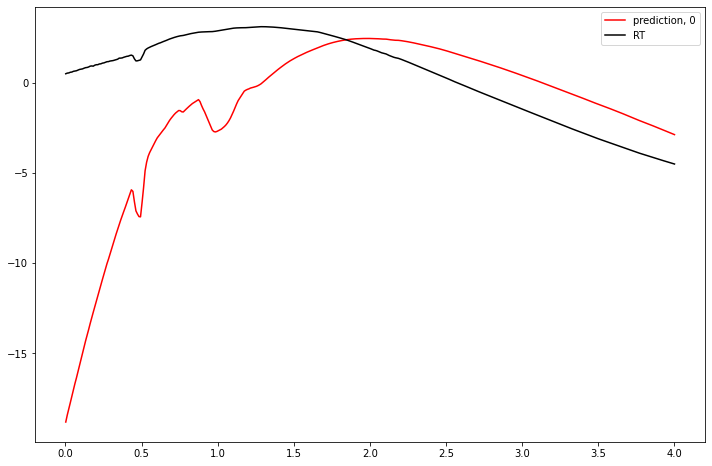

3642
{'Tstar': 4938.032432519834, 'logL_star': 1.8823843288381474, 'logM_disk': -3.626849268785369, 'logR_disk': 2.4724264342131166, 'h_0': 0.33275177337732903, 'logR_in': -0.03584283223431006, 'gamma': 0.55746801544118, 'beta': 1.6933597279342074, 'logM_env': -2.707476136550185, 'logR_env': 3.2183508036621182, 'f_cav': 0.6948251398388566, 'ksi': 1.1958646722598005, 'loga_max': 3.082323190655271, 'p': 2.5616881707828036, 'incl': 30.047253689328816, 'filename': 'Tstar_4938.032_logLstar_1.2_logMdisk_-3.627_logRdisk_2.472_h0_0.333_logRin_-0.036_gamma_0.557_beta_1.693_logMenv_-2.707_logRenv_3.218_fcav_0.695_ksi_1.196_logamax_3.082_p_2.562_incl_30.047.hdf5'}


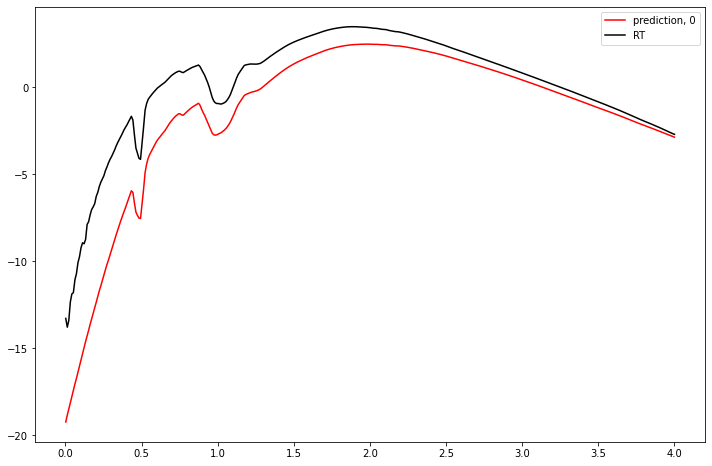

2960
{'Tstar': 4197.783694148511, 'logL_star': 2.674316240759851, 'logM_disk': -6.014305453126449, 'logR_disk': 1.9382363035937702, 'h_0': 0.40980855777468816, 'logR_in': 0.8099111681113382, 'gamma': 1.041408747896234, 'beta': 1.6841072765772822, 'logM_env': -5.097652418564133, 'logR_env': 2.5772030570026847, 'f_cav': 0.8497109721065724, 'ksi': 1.3146654920064222, 'loga_max': 2.490274799380739, 'p': 3.3886498391875643, 'incl': 12.100867925456692, 'filename': 'Tstar_4197.784_logLstar_2.674_logMdisk_-6.014_logRdisk_1.938_h0_0.410_logRin_0.810_gamma_1.041_beta_1.684_logMenv_-5.098_logRenv_2.577_fcav_0.850_ksi_1.315_logamax_2.490_p_3.389_incl_12.101.hdf5'}


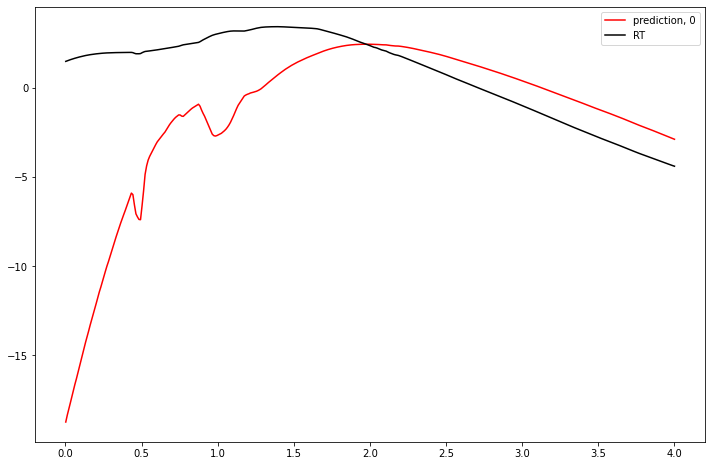

1531
{'Tstar': 3771.913058829131, 'logL_star': -0.3724256692103094, 'logM_disk': -6.0469186040302585, 'logR_disk': 2.582099187380905, 'h_0': 0.43973105032318455, 'logR_in': -0.730731053979073, 'gamma': 1.0388154693814695, 'beta': 1.1459971310016255, 'logM_env': -5.1860178597470385, 'logR_env': 3.169152454911406, 'f_cav': 0.8062271605359188, 'ksi': 0.655276051333978, 'loga_max': 1.4191160170368584, 'p': 3.918147292562, 'incl': 69.36240954562588, 'filename': 'Tstar_3771.913_logLstar_-0.372_logMdisk_-6.047_logRdisk_2.582_h0_0.440_logRin_-0.731_gamma_1.039_beta_1.146_logMenv_-5.186_logRenv_3.169_fcav_0.806_ksi_0.655_logamax_1.419_p_3.918_incl_69.362.hdf5'}


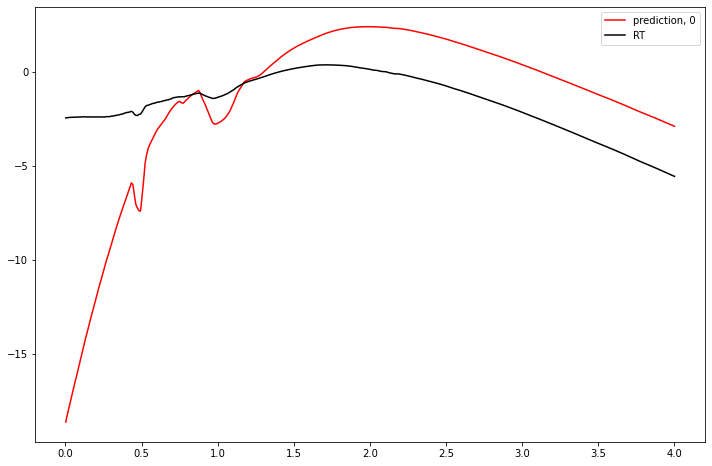

1673
{'Tstar': 3094.507264372422, 'logL_star': -0.9951345156238348, 'logM_disk': -3.854913645087729, 'logR_disk': 1.7627527590206178, 'h_0': 0.4193871480306466, 'logR_in': 1.3497079816893307, 'gamma': 0.2490462648534342, 'beta': 1.5866112432247268, 'logM_env': -6.582806004684893, 'logR_env': 3.126464338227532, 'f_cav': 0.8322724226854381, 'ksi': 1.2220157679042454, 'loga_max': 0.9171268222306161, 'p': 3.4555055240728643, 'incl': 62.30905546447396, 'filename': 'Tstar_3094.507_logLstar_-0.995_logMdisk_-3.855_logRdisk_1.763_h0_0.419_logRin_1.350_gamma_0.249_beta_1.587_logMenv_-6.583_logRenv_3.126_fcav_0.832_ksi_1.222_logamax_0.917_p_3.456_incl_62.309.hdf5'}


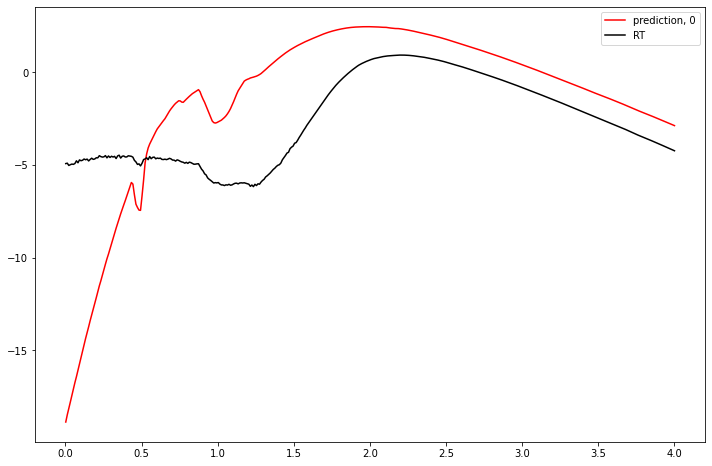

3165
{'Tstar': 4317.7627279528815, 'logL_star': 2.6194751563022356, 'logM_disk': -7.410163156853554, 'logR_disk': 2.8372347020303144, 'h_0': 0.03144157141704225, 'logR_in': 2.041202711448006, 'gamma': 0.6831052384773233, 'beta': 0.9445440388848744, 'logM_env': -5.630042944279504, 'logR_env': 3.317471087515333, 'f_cav': 0.5760809267251604, 'ksi': 1.26866212781864, 'loga_max': 0.30094039476703843, 'p': 3.146192373452747, 'incl': 21.120524855182754, 'filename': 'Tstar_4317.763_logLstar_2.619_logMdisk_-7.410_logRdisk_2.837_h0_0.031_logRin_2.041_gamma_0.683_beta_0.945_logMenv_-5.630_logRenv_3.317_fcav_0.576_ksi_1.269_logamax_0.301_p_3.146_incl_21.121.hdf5'}


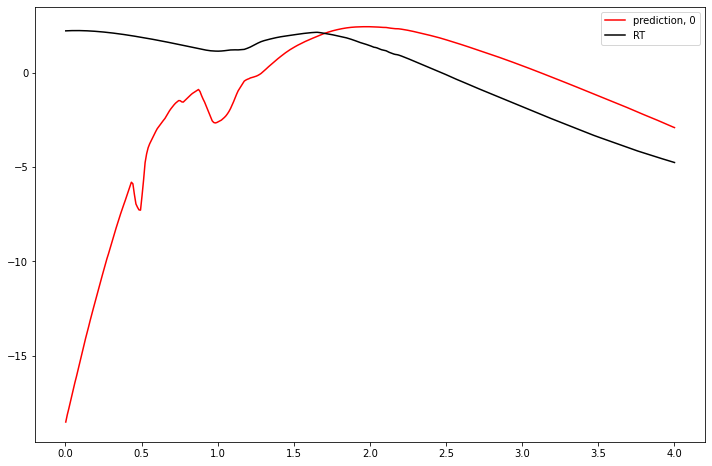

2134
{'Tstar': 4810.202486482847, 'logL_star': 2.9364247981962888, 'logM_disk': -3.757564793834354, 'logR_disk': 1.9612028344969163, 'h_0': 0.4683189623690031, 'logR_in': 1.6025977309460457, 'gamma': 0.006121189864400302, 'beta': 0.9530919165632246, 'logM_env': -7.307596381104712, 'logR_env': 3.7930889799654017, 'f_cav': 0.13286305127884815, 'ksi': 0.8509885469584657, 'loga_max': 0.1789913150278587, 'p': 3.402846947404361, 'incl': 42.65191607934176, 'filename': 'Tstar_4810.202_logLstar_2.936_logMdisk_-3.758_logRdisk_1.961_h0_0.468_logRin_1.603_gamma_0.006_beta_0.953_logMenv_-7.308_logRenv_3.793_fcav_0.133_ksi_0.851_logamax_0.179_p_3.403_incl_42.652.hdf5'}


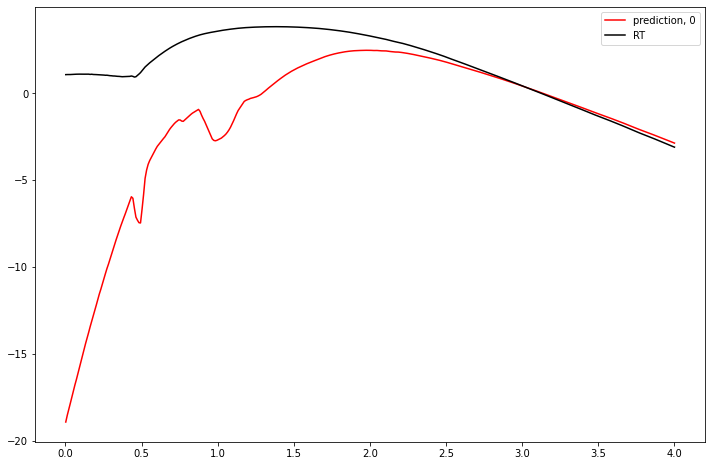

2434
{'Tstar': 3611.4322955709085, 'logL_star': 2.9632542193651727, 'logM_disk': -3.7524554454473282, 'logR_disk': 2.308139744423081, 'h_0': 0.4185794788763272, 'logR_in': 0.44061431310968, 'gamma': 1.8768353153389987, 'beta': 1.7560041706986804, 'logM_env': -3.605464331084492, 'logR_env': 3.238025497131119, 'f_cav': 0.5621489612063153, 'ksi': 1.082031089829708, 'loga_max': 3.8969770988826538, 'p': 3.7646552356820187, 'incl': 8.075425435583988, 'filename': 'Tstar_3611.432_logLstar_2.963_logMdisk_-3.752_logRdisk_2.308_h0_0.419_logRin_0.441_gamma_1.877_beta_1.756_logMenv_-3.605_logRenv_3.238_fcav_0.562_ksi_1.082_logamax_3.897_p_3.765_incl_8.075.hdf5'}


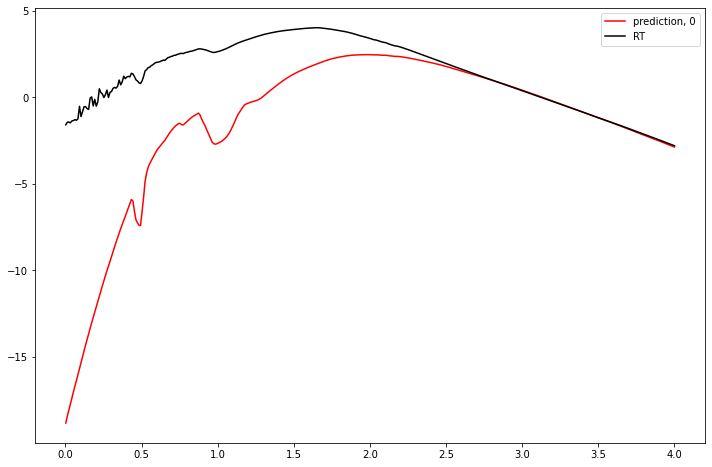

1691
{'Tstar': 4132.3841729432, 'logL_star': 1.643595614431729, 'logM_disk': -3.850575946831051, 'logR_disk': 1.7340807495886192, 'h_0': 0.1126589896636452, 'logR_in': 0.6699304359818101, 'gamma': 1.6716413697837262, 'beta': 1.4777470009146512, 'logM_env': -5.182067762334998, 'logR_env': 3.3788785987229817, 'f_cav': 0.20090052587607896, 'ksi': 0.8632270618251275, 'loga_max': 0.414414518718812, 'p': 2.977848718268094, 'incl': 28.259681868655633, 'filename': 'Tstar_4132.384_logLstar_1.644_logMdisk_-3.851_logRdisk_1.734_h0_0.113_logRin_0.670_gamma_1.672_beta_1.478_logMenv_-5.182_logRenv_3.379_fcav_0.201_ksi_0.863_logamax_0.414_p_2.978_incl_28.260.hdf5'}


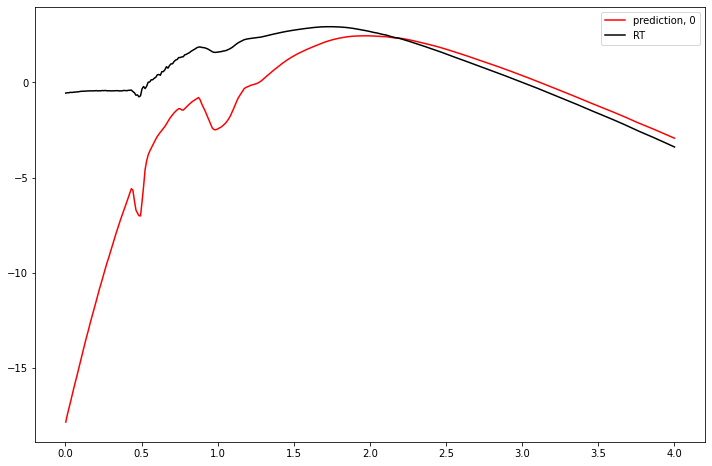

1900
{'Tstar': 4483.251778679129, 'logL_star': 2.8824018459557905, 'logM_disk': -4.207346704740191, 'logR_disk': 1.9528203761899499, 'h_0': 0.04364069844993389, 'logR_in': -0.16904761393615553, 'gamma': 0.40426965475391086, 'beta': 1.6712277093746422, 'logM_env': -4.622767702265154, 'logR_env': 2.826023201403366, 'f_cav': 0.4086316193935869, 'ksi': 1.0059396882672664, 'loga_max': 2.6064172966293557, 'p': 3.6040290335711456, 'incl': 71.57714026381741, 'filename': 'Tstar_4483.252_logLstar_2.2_logMdisk_-4.207_logRdisk_1.953_h0_0.044_logRin_-0.169_gamma_0.404_beta_1.671_logMenv_-4.623_logRenv_2.826_fcav_0.409_ksi_1.006_logamax_2.606_p_3.604_incl_71.577.hdf5'}


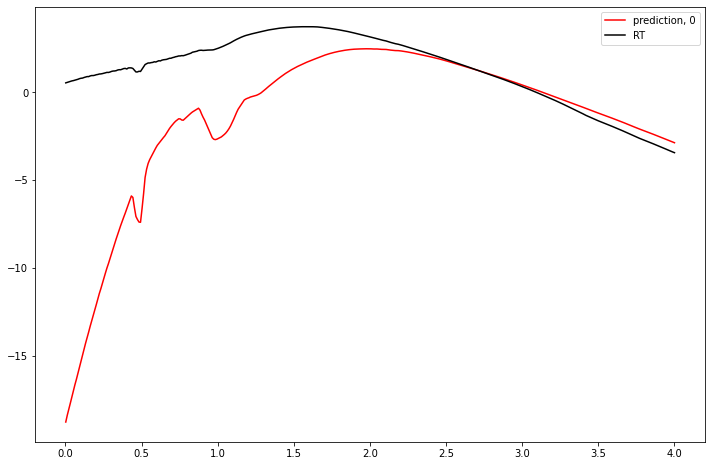

1924
{'Tstar': 4016.367424328872, 'logL_star': 1.2292737811681853, 'logM_disk': -7.320111566690301, 'logR_disk': 2.9398798306069214, 'h_0': 0.0820388058206032, 'logR_in': -0.6268877808466244, 'gamma': 1.8035824809275829, 'beta': 1.824186455383456, 'logM_env': -6.537610827645604, 'logR_env': 3.4307203368805084, 'f_cav': 0.20483822384794986, 'ksi': 1.1018594870777962, 'loga_max': 2.015015820992773, 'p': 3.1759714150924747, 'incl': 39.014932407307356, 'filename': 'Tstar_4016.367_logLstar_1.229_logMdisk_-7.320_logRdisk_2.940_h0_0.082_logRin_-0.627_gamma_1.804_beta_1.824_logMenv_-6.538_logRenv_3.431_fcav_0.205_ksi_1.102_logamax_2.015_p_3.176_incl_39.015.hdf5'}


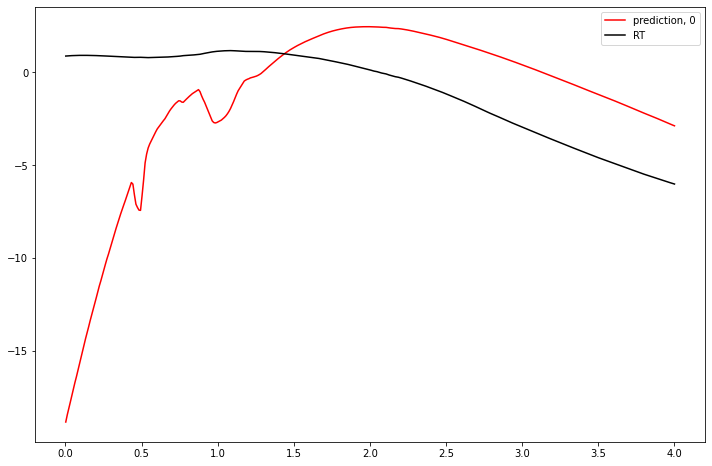

2463
{'Tstar': 3446.0288415545083, 'logL_star': 1.6501657759877246, 'logM_disk': -7.322359822379312, 'logR_disk': 1.0342941209275893, 'h_0': 0.10186158119452073, 'logR_in': 0.5521379668995821, 'gamma': 1.304387149885593, 'beta': 0.8711897996596807, 'logM_env': -4.399857361257082, 'logR_env': 3.0187043303016674, 'f_cav': 0.9708046506472083, 'ksi': 0.5223038712515571, 'loga_max': 4.664101832283206, 'p': 3.3357644477708743, 'incl': 2.58115927294266, 'filename': 'Tstar_3446.029_logLstar_1.650_logMdisk_-7.322_logRdisk_1.034_h0_0.102_logRin_0.552_gamma_1.304_beta_0.871_logMenv_-4.400_logRenv_3.019_fcav_0.971_ksi_0.522_logamax_4.4_p_3.336_incl_2.581.hdf5'}


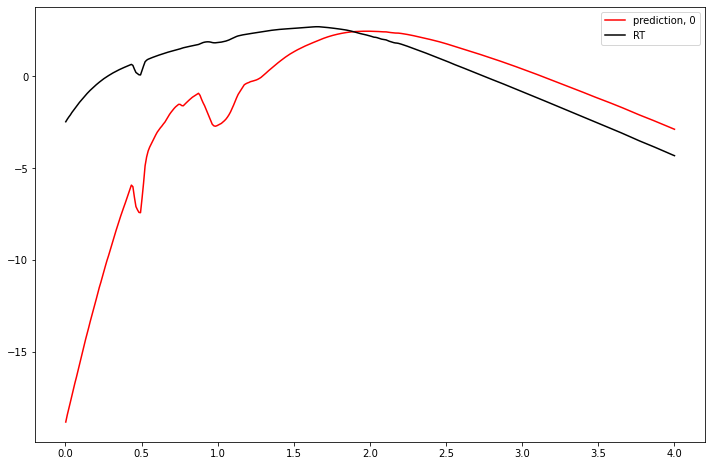

897
{'Tstar': 3913.414576184521, 'logL_star': -0.4111655809213085, 'logM_disk': -7.5409193836014285, 'logR_disk': 0.5408781111205203, 'h_0': 0.2487270337611394, 'logR_in': 0.4775484256073488, 'gamma': 0.8588772951044475, 'beta': 0.985817781948721, 'logM_env': -2.798140170319332, 'logR_env': 2.773358660946926, 'f_cav': 0.04203938250575199, 'ksi': 1.2094601914398524, 'loga_max': 1.3895109589394263, 'p': 2.92183856413293, 'incl': 25.12826458251687, 'filename': 'Tstar_3913.415_logLstar_-0.411_logMdisk_-7.541_logRdisk_0.541_h0_0.249_logRin_0.478_gamma_0.859_beta_0.986_logMenv_-2.798_logRenv_2.773_fcav_0.042_ksi_1.209_logamax_1.390_p_2.922_incl_25.128.hdf5'}


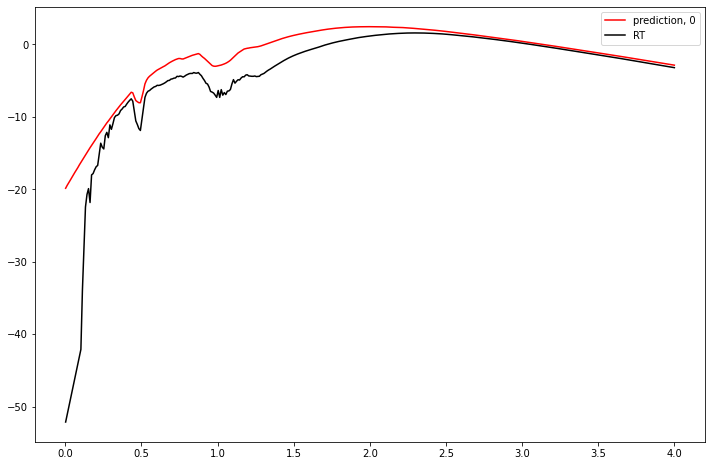

3213
{'Tstar': 4900.359309058335, 'logL_star': -0.9928857674155268, 'logM_disk': -3.408701308351831, 'logR_disk': 1.645327879368307, 'h_0': 0.048898419140991266, 'logR_in': -0.9248090517348697, 'gamma': 1.8911958698087294, 'beta': 1.8129200403458403, 'logM_env': -6.699347756668278, 'logR_env': 3.7832298165427902, 'f_cav': 0.028322620201093742, 'ksi': 1.049763671987511, 'loga_max': 3.4130335666411593, 'p': 3.183424816031223, 'incl': 21.173165264424647, 'filename': 'Tstar_4900.359_logLstar_-0.993_logMdisk_-3.409_logRdisk_1.645_h0_0.049_logRin_-0.925_gamma_1.891_beta_1.813_logMenv_-6.699_logRenv_3.783_fcav_0.028_ksi_1.050_logamax_3.413_p_3.183_incl_21.173.hdf5'}


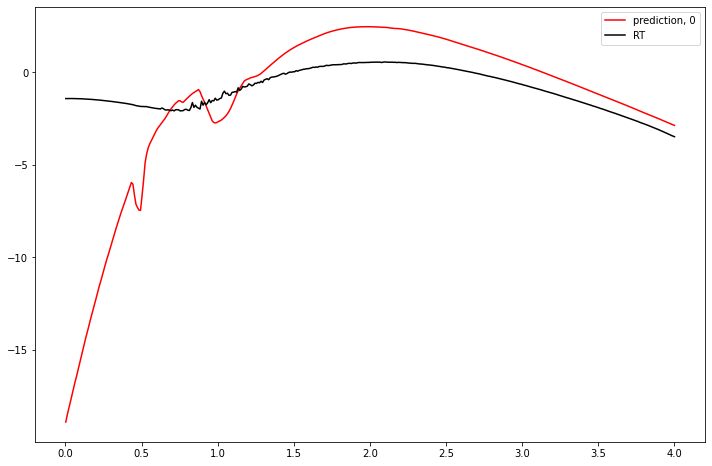

2805
{'Tstar': 4653.71148015726, 'logL_star': -0.1958916082832758, 'logM_disk': -2.3468200890428967, 'logR_disk': 0.019657450514340563, 'h_0': 0.45254460973873695, 'logR_in': -0.5105854677974091, 'gamma': 0.4919325729895034, 'beta': 0.5595536394658599, 'logM_env': -6.977665370003933, 'logR_env': 3.6656466117133757, 'f_cav': 0.6193186903254694, 'ksi': 1.3904548816352889, 'loga_max': 2.6712194255110093, 'p': 4.105115171136826, 'incl': 3.035114009419156, 'filename': 'Tstar_4653.711_logLstar_-0.196_logMdisk_-2.347_logRdisk_0.020_h0_0.453_logRin_-0.511_gamma_0.492_beta_0.560_logMenv_-6.978_logRenv_3.6_fcav_0.619_ksi_1.390_logamax_2.671_p_4.105_incl_3.035.hdf5'}


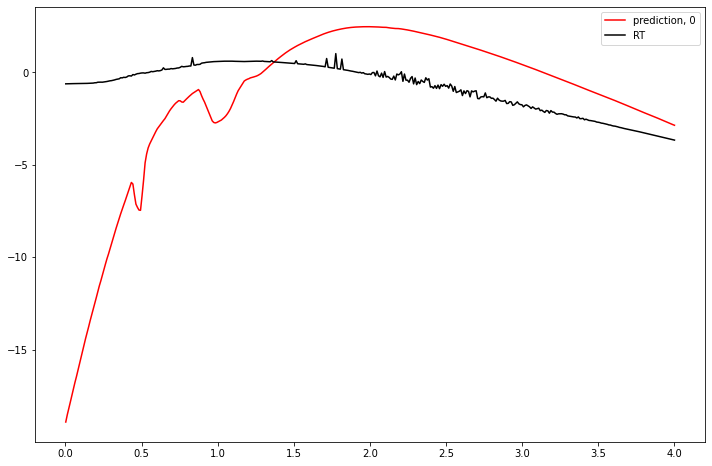

1747
{'Tstar': 3999.421137122341, 'logL_star': 1.571952071817861, 'logM_disk': -2.5633991139845147, 'logR_disk': 1.3407390193405493, 'h_0': 0.04852653589039957, 'logR_in': 1.1826466051088431, 'gamma': 1.3871339733829766, 'beta': 0.7588763209448877, 'logM_env': -7.880598044830964, 'logR_env': 3.645953878351132, 'f_cav': 0.6746129053936948, 'ksi': 0.7010195876496986, 'loga_max': 0.3045071176834187, 'p': 4.034364963680406, 'incl': 65.03798093839715, 'filename': 'Tstar_3999.421_logLstar_1.572_logMdisk_-2.563_logRdisk_1.341_h0_0.049_logRin_1.183_gamma_1.387_beta_0.759_logMenv_-7.1_logRenv_3.646_fcav_0.675_ksi_0.701_logamax_0.305_p_4.034_incl_65.038.hdf5'}


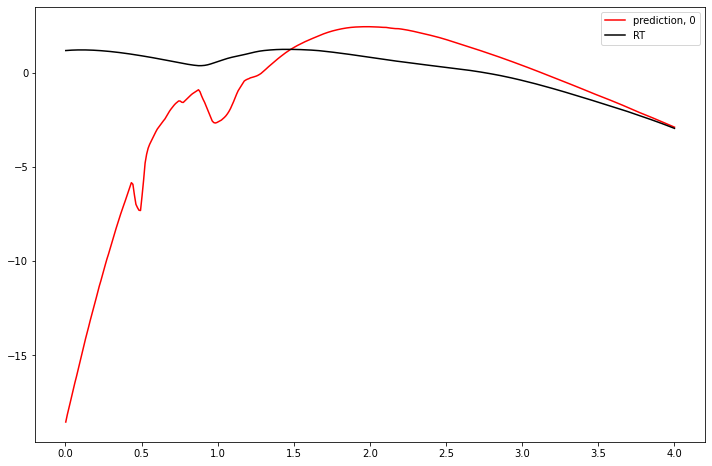

612
{'Tstar': 3603.5725726457913, 'logL_star': 0.5221909440178718, 'logM_disk': -2.445795814210224, 'logR_disk': 0.7796973238908924, 'h_0': 0.34499777427270867, 'logR_in': -0.30760465492289124, 'gamma': 1.5025905640763408, 'beta': 1.7172442090714488, 'logM_env': -7.49333044985185, 'logR_env': 2.6432938018029946, 'f_cav': 0.19253095223537614, 'ksi': 1.36387741659455, 'loga_max': 4.761922024328577, 'p': 4.466809226807355, 'incl': 89.56723244342243, 'filename': 'Tstar_3603.573_logLstar_0.522_logMdisk_-2.446_logRdisk_0.780_h0_0.345_logRin_-0.308_gamma_1.503_beta_1.717_logMenv_-7.493_logRenv_2.643_fcav_0.193_ksi_1.364_logamax_4.762_p_4.467_incl_89.567.hdf5'}


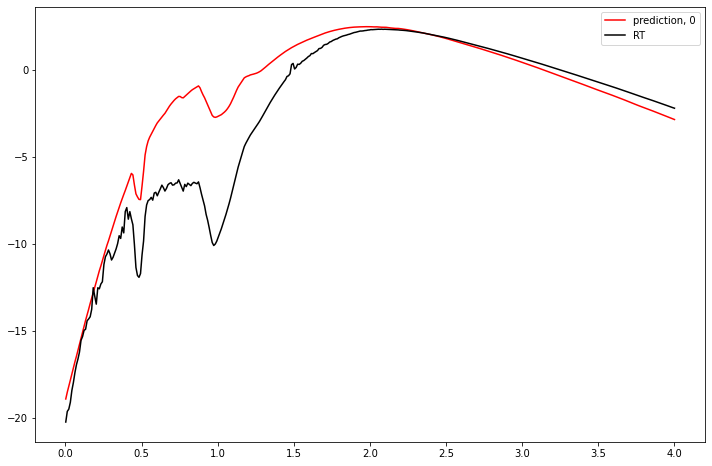

1028
{'Tstar': 3623.556495512641, 'logL_star': 2.2648694235507763, 'logM_disk': -4.797142924043743, 'logR_disk': 1.198091569378546, 'h_0': 0.296791584719412, 'logR_in': -0.6849716193166704, 'gamma': 1.1501537147688305, 'beta': 0.9003699165585889, 'logM_env': -3.8962729693925615, 'logR_env': 2.5988818370677382, 'f_cav': 0.5561870303371658, 'ksi': 1.0987733571130969, 'loga_max': 3.0008001461006915, 'p': 3.891449824231942, 'incl': 71.34240548768939, 'filename': 'Tstar_3623.556_logLstar_2.265_logMdisk_-4.797_logRdisk_1.198_h0_0.297_logRin_-0.685_gamma_1.150_beta_0.900_logMenv_-3.896_logRenv_2.599_fcav_0.556_ksi_1.099_logamax_3.001_p_3.891_incl_71.342.hdf5'}


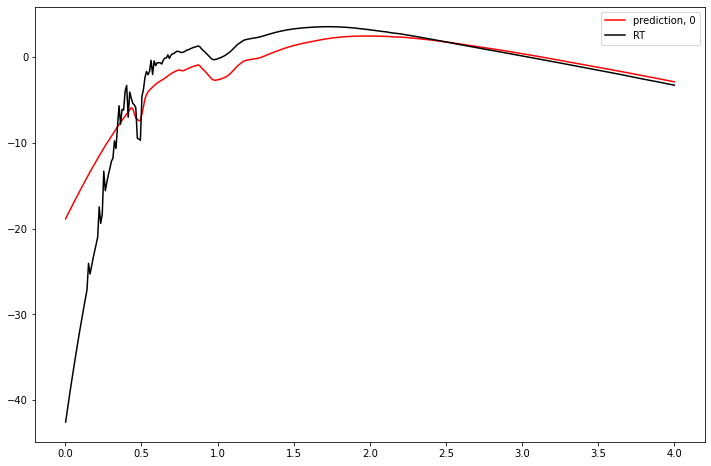

2651
{'Tstar': 4213.925920896153, 'logL_star': -0.1546197824499549, 'logM_disk': -4.0403348156959265, 'logR_disk': 0.890812055523577, 'h_0': 0.17324681321024804, 'logR_in': 0.283353504142148, 'gamma': 1.543182185736987, 'beta': 0.9463752316518494, 'logM_env': -3.1034435031069005, 'logR_env': 2.718514566354274, 'f_cav': 0.4546013781095411, 'ksi': 1.0460737051033044, 'loga_max': 0.5119738167816958, 'p': 3.888087700415018, 'incl': 85.29614116366348, 'filename': 'Tstar_4213.926_logLstar_-0.155_logMdisk_-4.040_logRdisk_0.891_h0_0.173_logRin_0.283_gamma_1.543_beta_0.946_logMenv_-3.103_logRenv_2.719_fcav_0.455_ksi_1.046_logamax_0.512_p_3.8_incl_85.296.hdf5'}


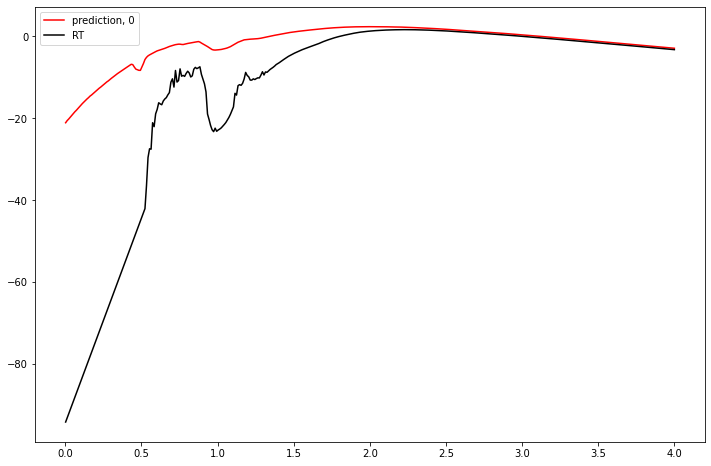

2883
{'Tstar': 4752.880696562164, 'logL_star': 0.5873467635003196, 'logM_disk': -7.873199390773534, 'logR_disk': 2.5283489219388278, 'h_0': 0.10781312767679486, 'logR_in': 1.2297186577157424, 'gamma': 1.7933324575736067, 'beta': 0.8418407740544791, 'logM_env': -5.001989918867151, 'logR_env': 3.5374739962671358, 'f_cav': 0.44757291831543483, 'ksi': 1.447542801671677, 'loga_max': 1.974692041953681, 'p': 2.7025955838823013, 'incl': 53.1941209883449, 'filename': 'Tstar_4752.1_logLstar_0.587_logMdisk_-7.873_logRdisk_2.528_h0_0.108_logRin_1.230_gamma_1.793_beta_0.842_logMenv_-5.002_logRenv_3.537_fcav_0.448_ksi_1.448_logamax_1.975_p_2.703_incl_53.194.hdf5'}


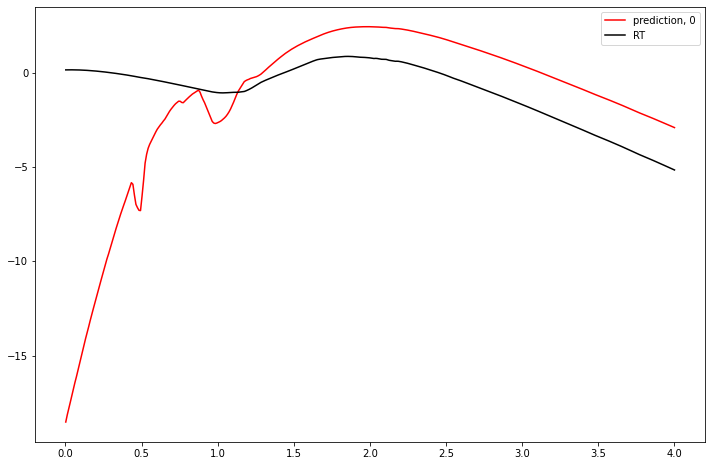

135
{'Tstar': 3819.0889585342734, 'logL_star': 2.5012320619817414, 'logM_disk': -3.1404527441562395, 'logR_disk': 2.6188276823311107, 'h_0': 0.31152420066982356, 'logR_in': 0.8529670725762826, 'gamma': 1.0694396748247057, 'beta': 0.6605712137742213, 'logM_env': -2.731445762051166, 'logR_env': 3.799485450174559, 'f_cav': 0.3020302695965321, 'ksi': 0.9022381809804996, 'loga_max': 2.7098236148329, 'p': 3.2529509899550213, 'incl': 22.54255382948695, 'filename': 'Tstar_3819.089_logLstar_2.501_logMdisk_-3.140_logRdisk_2.619_h0_0.312_logRin_0.853_gamma_1.069_beta_0.1_logMenv_-2.731_logRenv_3.799_fcav_0.302_ksi_0.902_logamax_2.710_p_3.253_incl_22.543.hdf5'}


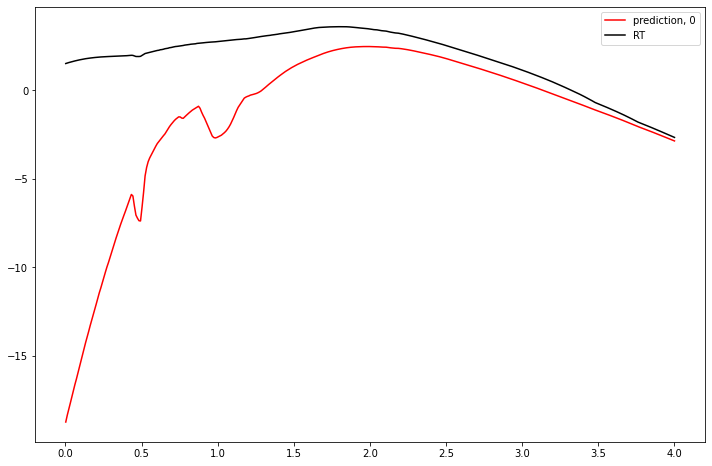

2097
{'Tstar': 4284.576763493182, 'logL_star': 1.35081659580106, 'logM_disk': -2.4312211490266353, 'logR_disk': 0.7966402597478406, 'h_0': 0.25821648046090045, 'logR_in': -0.972649799702903, 'gamma': 0.6686908525182805, 'beta': 1.164767004424347, 'logM_env': -3.5046894983764503, 'logR_env': 3.203677993132378, 'f_cav': 0.2957555378231238, 'ksi': 0.6988707261318335, 'loga_max': 3.2495415868300093, 'p': 3.144572493143392, 'incl': 61.50542828057556, 'filename': 'Tstar_4284.577_logLstar_1.351_logMdisk_-2.431_logRdisk_0.797_h0_0.258_logRin_-0.973_gamma_0.9_beta_1.165_logMenv_-3.505_logRenv_3.204_fcav_0.296_ksi_0.699_logamax_3.250_p_3.145_incl_61.505.hdf5'}


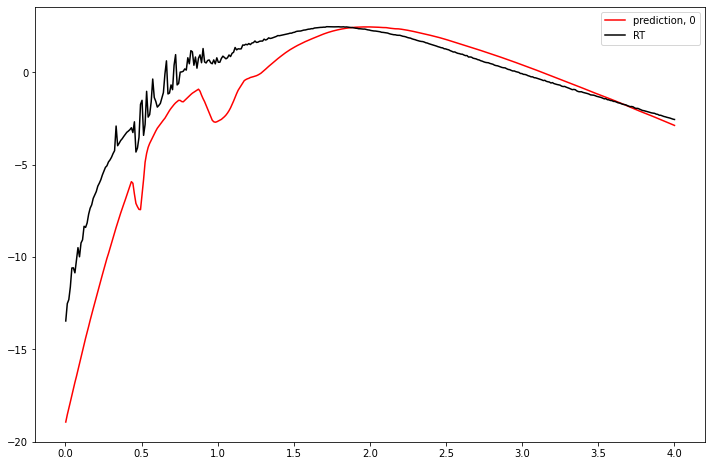

3503
{'Tstar': 3672.444924666167, 'logL_star': 0.959673780806567, 'logM_disk': -3.8636667213008824, 'logR_disk': 2.9937386437889657, 'h_0': 0.47738536059815706, 'logR_in': -0.00048418831374696936, 'gamma': 0.3892988525399196, 'beta': 1.101584562649303, 'logM_env': -4.2217387146091525, 'logR_env': 3.9939603964307837, 'f_cav': 0.4311962545538779, 'ksi': 1.265100378134716, 'loga_max': 3.5716667628645418, 'p': 2.51797603544249, 'incl': 26.713401736232647, 'filename': 'Tstar_3672.445_logLstar_0.960_logMdisk_-3.864_logRdisk_2.994_h0_0.477_logRin_-0.000_gamma_0.389_beta_1.102_logMenv_-4.222_logRenv_3.994_fcav_0.431_ksi_1.265_logamax_3.572_p_2.518_incl_26.713.hdf5'}


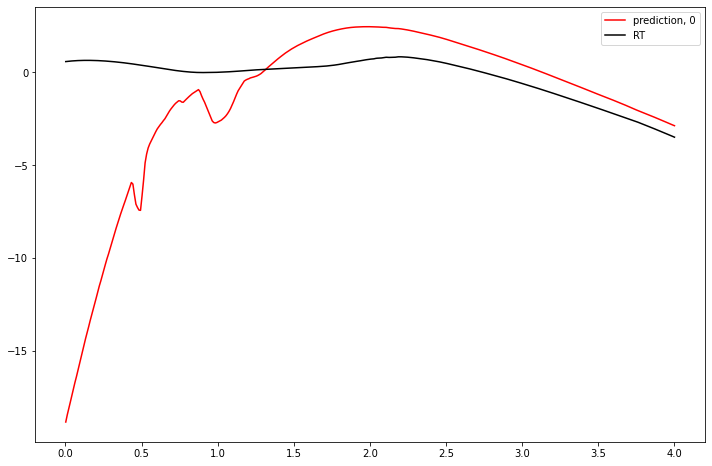

3777
{'Tstar': 3777.20676964199, 'logL_star': 2.330402249416544, 'logM_disk': -5.439988024712989, 'logR_disk': 1.5476744117999908, 'h_0': 0.3530355636572286, 'logR_in': 0.25398000971201085, 'gamma': 0.9195162771882266, 'beta': 1.3611816888619, 'logM_env': -2.98077616037014, 'logR_env': 3.328791393467218, 'f_cav': 0.070448915254167, 'ksi': 1.4948922883866689, 'loga_max': 2.3264686953445017, 'p': 3.9456844703027434, 'incl': 16.2758224694123, 'filename': 'Tstar_3777.207_logLstar_2.330_logMdisk_-5.440_logRdisk_1.548_h0_0.353_logRin_0.254_gamma_0.920_beta_1.361_logMenv_-2.981_logRenv_3.329_fcav_0.070_ksi_1.495_logamax_2.326_p_3.946_incl_16.276.hdf5'}


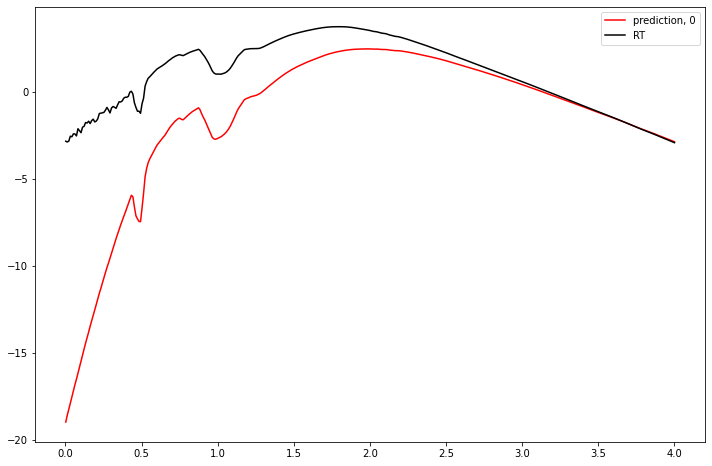

2365
{'Tstar': 4247.765050204427, 'logL_star': 2.298178565408248, 'logM_disk': -4.818589691316743, 'logR_disk': 2.998961281849855, 'h_0': 0.016133347329720375, 'logR_in': -0.9681501277283537, 'gamma': 0.8239498511767351, 'beta': 1.3043369040388386, 'logM_env': -5.3689163005039156, 'logR_env': 3.302886401571266, 'f_cav': 0.7818772338559562, 'ksi': 0.5955067313290908, 'loga_max': 4.526275080377936, 'p': 3.824261285103628, 'incl': 78.2841978427274, 'filename': 'Tstar_4247.765_logLstar_2.298_logMdisk_-4.819_logRdisk_2.999_h0_0.016_logRin_-0.968_gamma_0.824_beta_1.304_logMenv_-5.369_logRenv_3.303_fcav_0.782_ksi_0.596_logamax_4.526_p_3.824_incl_78.284.hdf5'}


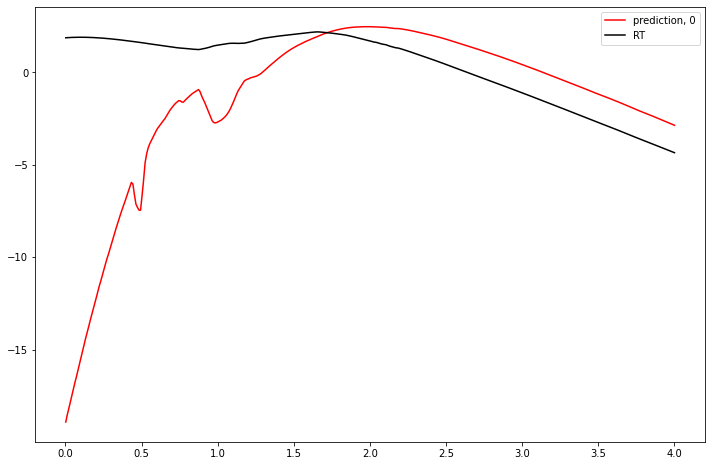

782
{'Tstar': 3146.2309739720054, 'logL_star': 0.4646215605722217, 'logM_disk': -5.53826779707483, 'logR_disk': 1.7924965595041265, 'h_0': 0.13663421480402635, 'logR_in': 1.6202888591765112, 'gamma': 0.49310795235400606, 'beta': 1.5732365831362962, 'logM_env': -6.033392684103492, 'logR_env': 2.814143433243156, 'f_cav': 0.10141815482182764, 'ksi': 1.4997336834281725, 'loga_max': 1.4309176074645187, 'p': 3.8387811740981617, 'incl': 84.00993620911885, 'filename': 'Tstar_3146.231_logLstar_0.465_logMdisk_-5.538_logRdisk_1.792_h0_0.137_logRin_1.620_gamma_0.493_beta_1.573_logMenv_-6.033_logRenv_2.814_fcav_0.101_ksi_1.500_logamax_1.431_p_3.839_incl_84.010.hdf5'}


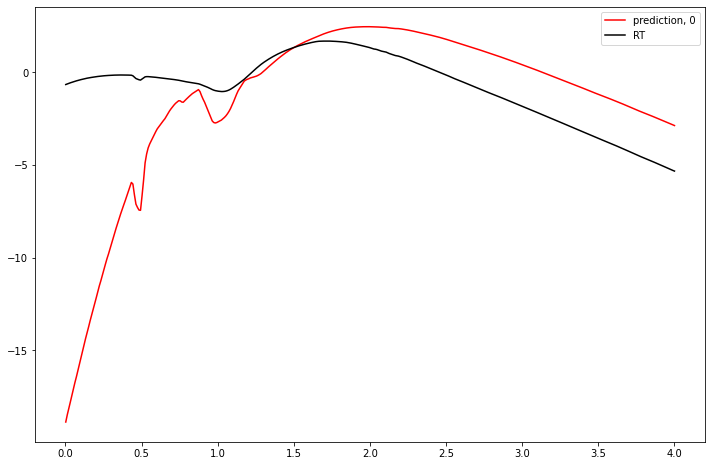

3767
{'Tstar': 4106.963836270006, 'logL_star': 2.349855151536145, 'logM_disk': -7.755670842766273, 'logR_disk': 0.9233542622564535, 'h_0': 0.0492386984113045, 'logR_in': 0.5274919468975963, 'gamma': 1.5860434636322778, 'beta': 0.5764412624401304, 'logM_env': -3.3207691557507237, 'logR_env': 3.8571486120383303, 'f_cav': 0.45857704021991447, 'ksi': 0.8898422744215773, 'loga_max': 2.1960230242952408, 'p': 4.2431223967177525, 'incl': 84.0499855059327, 'filename': 'Tstar_4106.964_logLstar_2.350_logMdisk_-7.756_logRdisk_0.923_h0_0.049_logRin_0.527_gamma_1.586_beta_0.576_logMenv_-3.321_logRenv_3.857_fcav_0.459_ksi_0.890_logamax_2.196_p_4.243_incl_84.050.hdf5'}


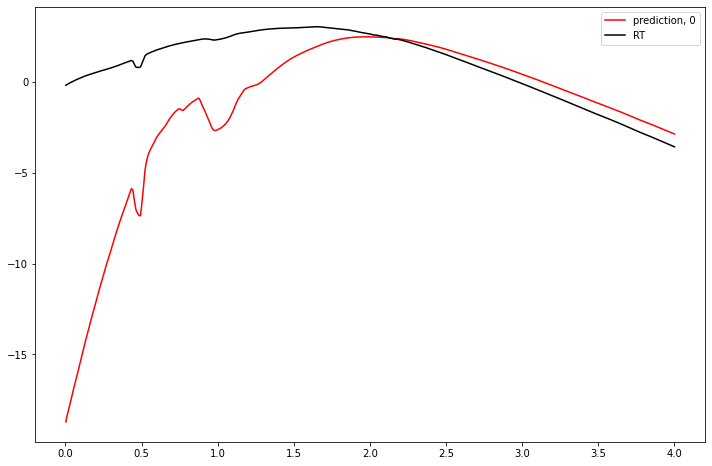

3015
{'Tstar': 4658.076888570255, 'logL_star': -0.057364148453797226, 'logM_disk': -4.187276870852481, 'logR_disk': 2.6752621354127415, 'h_0': 0.3050970152612735, 'logR_in': -0.4924596543818097, 'gamma': 1.1205998600469655, 'beta': 1.6008635998001812, 'logM_env': -7.162643323988559, 'logR_env': 2.8048681949904117, 'f_cav': 0.002105398150024873, 'ksi': 1.485021234993782, 'loga_max': 2.9544875455129787, 'p': 3.2556779494901713, 'incl': 8.705793713725116, 'filename': 'Tstar_4658.077_logLstar_-0.057_logMdisk_-4.187_logRdisk_2.675_h0_0.305_logRin_-0.492_gamma_1.121_beta_1.601_logMenv_-7.163_logRenv_2.805_fcav_0.002_ksi_1.485_logamax_2.954_p_3.256_incl_8.706.hdf5'}


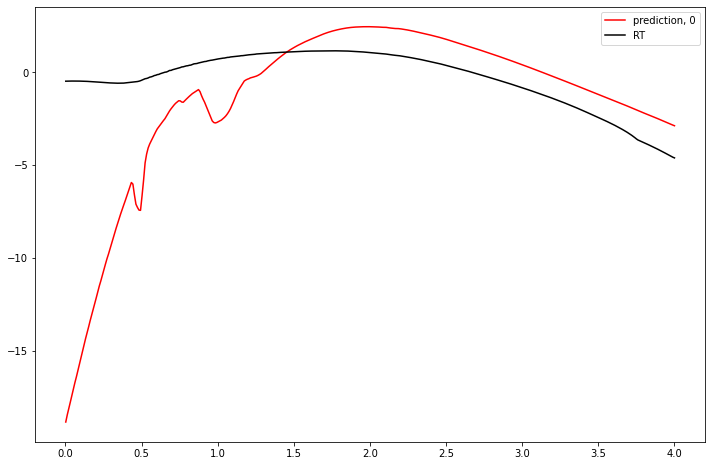

763
{'Tstar': 4166.51042187182, 'logL_star': 2.695039051553817, 'logM_disk': -7.091453305082874, 'logR_disk': 2.328400363906391, 'h_0': 0.21009546773768703, 'logR_in': 1.6267586890093297, 'gamma': 1.8763059280979804, 'beta': 1.1805231105297864, 'logM_env': -5.047578027205484, 'logR_env': 2.649056414552608, 'f_cav': 0.13380760516477047, 'ksi': 1.0817263535569346, 'loga_max': 0.7796191222600759, 'p': 4.371605964024319, 'incl': 37.87303323251089, 'filename': 'Tstar_41.510_logLstar_2.695_logMdisk_-7.091_logRdisk_2.328_h0_0.210_logRin_1.627_gamma_1.876_beta_1.181_logMenv_-5.048_logRenv_2.649_fcav_0.134_ksi_1.082_logamax_0.780_p_4.372_incl_37.873.hdf5'}


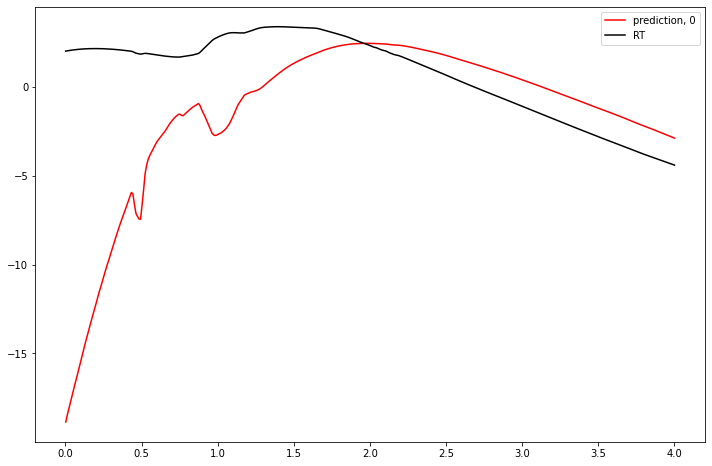

3408
{'Tstar': 3805.2116039405328, 'logL_star': 1.0064298363412059, 'logM_disk': -2.3248714152861645, 'logR_disk': 2.2789853395642607, 'h_0': 0.4569695910561495, 'logR_in': 1.0144544286917347, 'gamma': 1.7532717352967206, 'beta': 0.5748910832205204, 'logM_env': -7.313225694723765, 'logR_env': 3.6519845808526634, 'f_cav': 0.5052520418331675, 'ksi': 0.9522076762658935, 'loga_max': 4.623891188006254, 'p': 2.8532984184925074, 'incl': 67.73825325287785, 'filename': 'Tstar_3805.212_logLstar_1.006_logMdisk_-2.325_logRdisk_2.279_h0_0.457_logRin_1.014_gamma_1.753_beta_0.575_logMenv_-7.313_logRenv_3.652_fcav_0.505_ksi_0.952_logamax_4.624_p_2.853_incl_67.738.hdf5'}


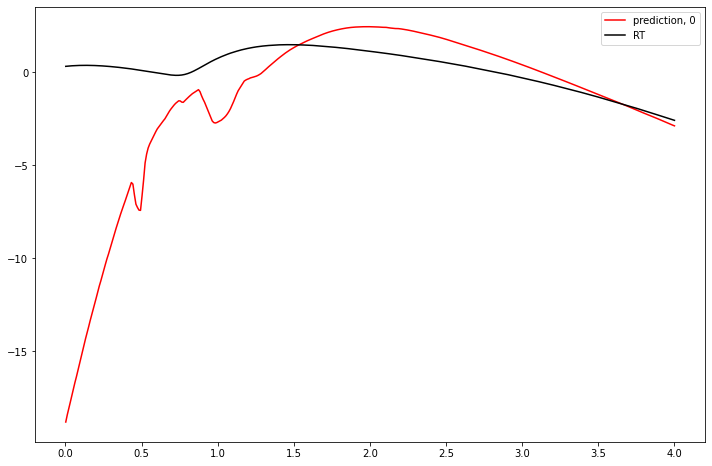

2
{'Tstar': 3383.576155930975, 'logL_star': 1.582639605569026, 'logM_disk': -4.782392384041774, 'logR_disk': 2.907338804471593, 'h_0': 0.2777447167042921, 'logR_in': 1.9941789777754124, 'gamma': 0.8750283525773478, 'beta': 0.5891332192043572, 'logM_env': -4.7654612282523825, 'logR_env': 3.936291189582004, 'f_cav': 0.3937995007030564, 'ksi': 1.393113741140088, 'loga_max': 4.037217612661526, 'p': 3.8265189084548457, 'incl': 61.686124472093695, 'filename': 'Tstar_3383.576_logLstar_1.583_logMdisk_-4.782_logRdisk_2.907_h0_0.278_logRin_1.994_gamma_0.875_beta_0.589_logMenv_-4.765_logRenv_3.936_fcav_0.394_ksi_1.393_logamax_4.037_p_3.827_incl_61.686.hdf5'}


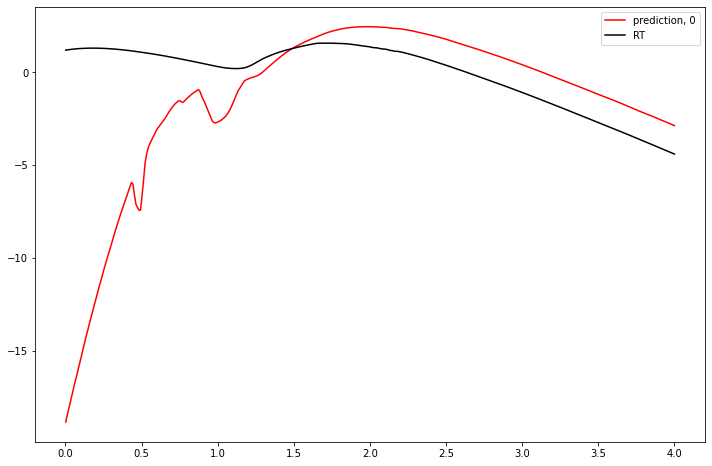

In [108]:
for i in range(len(predicted_SEDs_0)):
    print(sample[i])
    print(orig_dict[sample[i]])
    plt.figure(figsize=(12,8))
    plt.plot(np.log10(xvals),predicted_SEDs_0[i],c='r',label="prediction, 0")
    plt.plot(np.log10(xvals),point(sample[i])[1],c='k',label="RT")
    plt.legend()
    plt.show()

In [148]:
fitdata=np.load("new_fitdata.npy")
def load_slice_w2(param):
    return fitdata[param][:,0], fitdata[param][:,3]

In [184]:
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])

s_all=[]
s_all_orig=[]
for k in range(len(param_names)):
    slicepoints=[]
    slicepoints_orig=[]
    for i in range(31):
        point=[]
        for j in range(len(bases)):
            if j!=k:
                point.append(bases[j])
            else:
                point.append(ranges[k][0]+(i/30)*(ranges[k][1]-ranges[k][0]))
        slicepoints_orig.append(point)
        point1=[]
        for j in range(len(bases)):
            if j!=k:
                point1.append(bases[j])
            else:
                point1.append(ranges[k][0]+(i/30)*(ranges[k][1]-ranges[k][0]))
        slicepoints.append(orig_to_trans(point1))
    s_all.append(slicepoints)
    s_all_orig.append(slicepoints_orig)

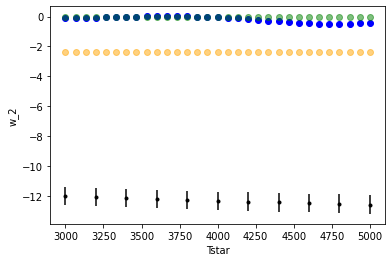

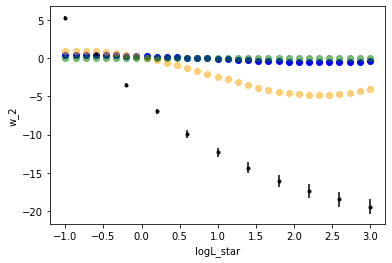

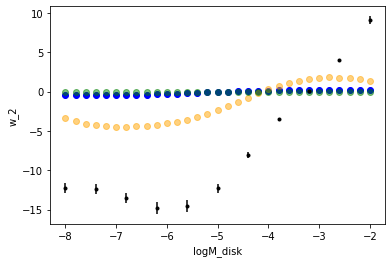

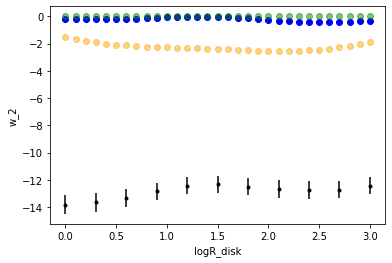

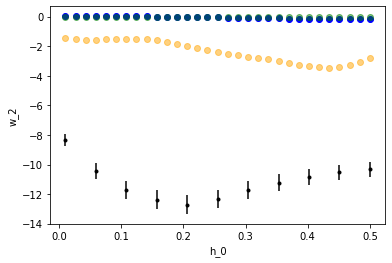

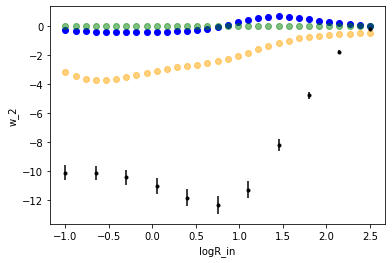

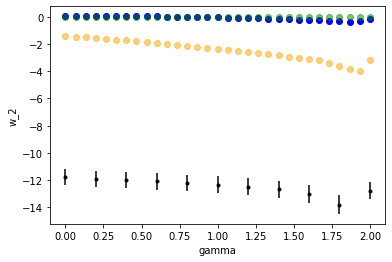

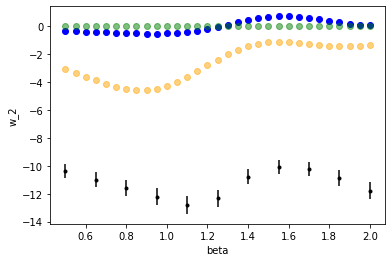

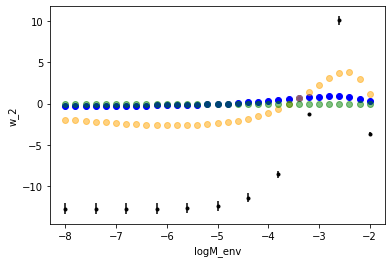

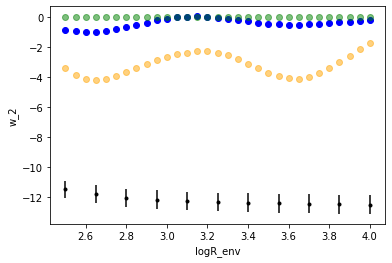

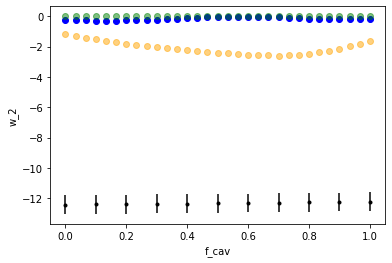

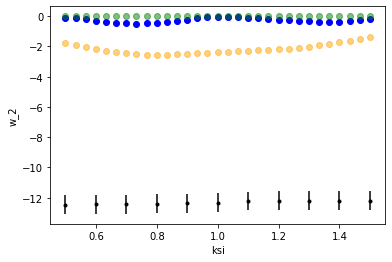

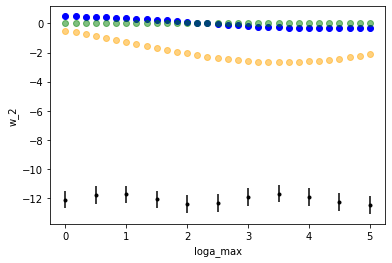

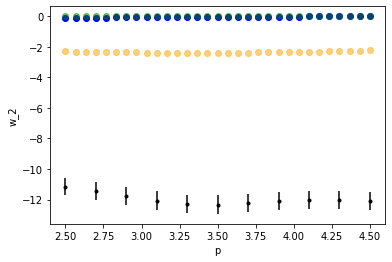

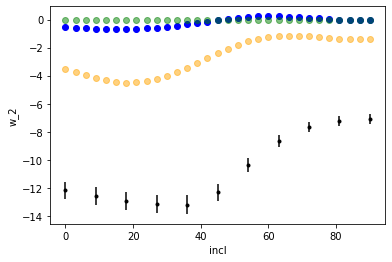

In [196]:
for param in range(len(param_names)):
       
    slice_weights =pred2(s_all[param],post)
    slice_weights0 =pred2(s_all[param],conv[0][2])
    slice_weights1 =pred2(s_all[param],post0)
    
    aX, ay = load_slice_w2(param)
    ayerr=[j*0.05 for j in ay]
    
#    akernel = kernels.ExpSquaredKernel(np.exp(post[param])) * np.var(ay)

#    agp = george.GP(akernel)
#    agp.compute(aX,ayerr)
#    ax_pred = np.linspace(ranges[param][0],ranges[param][1],500)
#    apred, apred_var = agp.predict(ay, ax_pred, return_var=True)
    
#    plt.fill_between(ax_pred, apred - np.sqrt(apred_var), apred + np.sqrt(apred_var),
#                    color="b", alpha=0.2)
#    plt.plot(ax_pred, apred, "r", lw=1.5, alpha=0.5)
    plt.errorbar(aX, ay, ayerr,fmt=".k", capsize=0)

    plt.scatter(np.array(s_all_orig[param])[:,param],slice_weights,c='b',label='')
    plt.scatter(np.array(s_all_orig[param])[:,param],slice_weights0,c='orange',alpha=0.5)
    plt.scatter(np.array(s_all_orig[param])[:,param],slice_weights1,c='g',alpha=0.5)

    plt.xlabel(param_names[param])
    plt.ylabel("w_2")
    plt.show()